In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import time
import warnings
import numpy as np
import nltk
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics.classification import accuracy_score, log_loss
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from imblearn.over_sampling import SMOTE
from collections import Counter
from scipy.sparse import hstack
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC

from collections import Counter, defaultdict
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import math
from sklearn.metrics import normalized_mutual_info_score
from sklearn.ensemble import RandomForestClassifier
warnings.filterwarnings("ignore")

from mlxtend.classifier import StackingClassifier

from sklearn import model_selection
from sklearn.linear_model import LogisticRegression


/home/sarthak/.local/lib/python3.6/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


In [2]:
data=pd.read_csv('/home/sarthak/Cancer diagonisis/msk-redefining-cancer-treatment/training_variants')

In [3]:
data.head()

,ID,Gene,Variation,Class
0,0,FAM58A,Truncating Mutations,1
1,1,CBL,W802*,2
2,2,CBL,Q249E,2
3,3,CBL,N454D,3
4,4,CBL,L399V,4


In [4]:
data.shape

(3321, 4)

In [5]:
data.columns.values

array(['ID', 'Gene', 'Variation', 'Class'], dtype=object)

In [6]:
# note the seprator in this file
data_text =pd.read_csv("/home/sarthak/Cancer diagonisis/msk-redefining-cancer-treatment/training_text",sep="\|\|",engine="python",names=["ID","TEXT"],skiprows=1)
print('Number of data points : ', data_text.shape[0])
print('Number of features : ', data_text.shape[1])
print('Features : ', data_text.columns.values)
data_text.head()

Number of data points :  3321
Number of features :  2
Features :  ['ID' 'TEXT']


,ID,TEXT
0,0,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,Abstract Background Non-small cell lung canc...
2,2,Abstract Background Non-small cell lung canc...
3,3,Recent evidence has demonstrated that acquired...
4,4,Oncogenic mutations in the monomeric Casitas B...


In [7]:
# loading stop words from nltk library
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/sarthak/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [8]:
data_text.shape

(3321, 2)

In [9]:
#fuction for text preprocessing
def nlp_preprocessing(total_text, index, column):
    if type(total_text) is not int:
        string = ""
        # replace every special char with space
        total_text = re.sub('[^a-zA-Z0-9\n]', ' ', total_text)
        # replace multiple spaces with single space
        total_text = re.sub('\s+',' ', total_text)
        # converting all the chars into lower-case.
        total_text = total_text.lower()
        
        for word in total_text.split():
        # if the word is a not a stop word then retain that word from the data
            if not word in stop_words:
                string += word + " "
        
        data_text[column][index] = string

In [19]:
#text processing stage.
start_time = time.clock()
for index, row in data_text.iterrows():
    if type(row['TEXT']) is str:
        nlp_preprocessing(row['TEXT'], index, 'TEXT')
    else:
        print("there is no text description for id:",index)
        #print (print(data_text.loc[index]))
        data_text=data_text.drop(index)
        

print('Time took for preprocessing the text :',time.clock() - start_time, "seconds")

there is no text description for id: 1109
there is no text description for id: 1277
there is no text description for id: 1407
there is no text description for id: 1639
there is no text description for id: 2755
Time took for preprocessing the text : 156.00438099999997 seconds


In [20]:
data_text.shape

(3316, 2)

In [21]:
result= pd.merge(data,data_text,on='ID',how='right');
result.head()

,ID,Gene,Variation,Class,TEXT
0,0,FAM58A,Truncating Mutations,1,cyclin dependent kinases cdks regulate variety...
1,1,CBL,W802*,2,abstract background non small cell lung cancer...
2,2,CBL,Q249E,2,abstract background non small cell lung cancer...
3,3,CBL,N454D,3,recent evidence demonstrated acquired uniparen...
4,4,CBL,L399V,4,oncogenic mutations monomeric casitas b lineag...


In [22]:
#TEST,TRAIN CV data
result.shape

(3316, 5)

In [23]:
y_true = result['Class'].values
y_true

array([1, 2, 2, ..., 1, 4, 4])

In [24]:
y_true.shape

(3316,)

In [25]:
result.Gene      = result.Gene.str.replace('\s+', '_')
result.Variation = result.Variation.str.replace('\s+', '_')

In [26]:

# split the data into test and train by maintaining same distribution of output varaible 'y_true' [stratify=y_true]
X_train, test_df, y_train, y_test = train_test_split(result, y_true, stratify=y_true, test_size=0.2)
# split the train data into train and cross validation by maintaining same distribution of output varaible 'y_train' [stratify=y_train]
train_df, cv_df, y_train, y_cv = train_test_split(X_train, y_train, stratify=y_train, test_size=0.2)

In [27]:
print('Number of data points in train data:', train_df.shape)
print('Number of data points in test data:', test_df.shape)
print('Number of data points in cross validation data:', cv_df.shape)

Number of data points in train data: (2121, 5)
Number of data points in test data: (664, 5)
Number of data points in cross validation data: (531, 5)


In [28]:
# it returns a dict, keys as class labels and values as the number of data points in that class
train_class_distribution = train_df['Class'].value_counts().sort_index()
test_class_distribution = test_df['Class'].value_counts().sort_index()
cv_class_distribution = cv_df['Class'].value_counts().sort_index()

In [29]:
pd.__version__

'0.24.2'

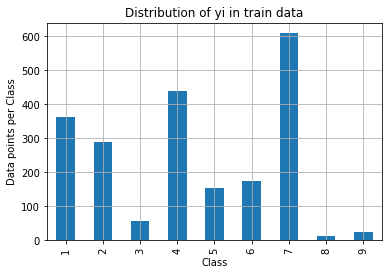

In [30]:
my_colors = 'rgbkymc'
train_class_distribution.plot(kind='bar')
plt.xlabel('Class')
plt.ylabel('Data points per Class')
plt.title('Distribution of yi in train data')
plt.grid()
plt.show()

In [31]:
sorted_yi = np.argsort(-train_class_distribution.values)
for i in sorted_yi:
    print('Number of data points in class', i+1, ':',train_class_distribution.values[i], '(', np.round((train_class_distribution.values[i]/train_df.shape[0]*100), 3), '%)')

Number of data points in class 7 : 609 ( 28.713 %)
Number of data points in class 4 : 439 ( 20.698 %)
Number of data points in class 1 : 362 ( 17.067 %)
Number of data points in class 2 : 289 ( 13.626 %)
Number of data points in class 6 : 174 ( 8.204 %)
Number of data points in class 5 : 155 ( 7.308 %)
Number of data points in class 3 : 57 ( 2.687 %)
Number of data points in class 9 : 24 ( 1.132 %)
Number of data points in class 8 : 12 ( 0.566 %)


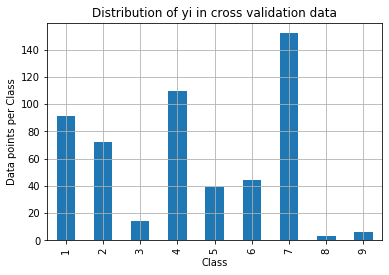

Number of data points in class 7 : 152 ( 28.625 %)
Number of data points in class 4 : 110 ( 20.716 %)
Number of data points in class 1 : 91 ( 17.137 %)
Number of data points in class 2 : 72 ( 13.559 %)
Number of data points in class 6 : 44 ( 8.286 %)
Number of data points in class 5 : 39 ( 7.345 %)
Number of data points in class 3 : 14 ( 2.637 %)
Number of data points in class 9 : 6 ( 1.13 %)
Number of data points in class 8 : 3 ( 0.565 %)


In [32]:
my_colors = 'rgbkymc'
cv_class_distribution.plot(kind='bar')
plt.xlabel('Class')
plt.ylabel('Data points per Class')
plt.title('Distribution of yi in cross validation data')
plt.grid()
plt.show()

# ref: argsort https://docs.scipy.org/doc/numpy/reference/generated/numpy.argsort.html
# -(train_class_distribution.values): the minus sign will give us in decreasing order
sorted_yi = np.argsort(-train_class_distribution.values)
for i in sorted_yi:
    print('Number of data points in class', i+1, ':',cv_class_distribution.values[i], '(', np.round((cv_class_distribution.values[i]/cv_df.shape[0]*100), 3), '%)')

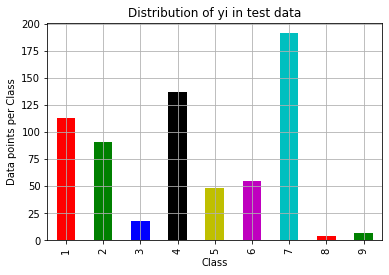

Number of data points in class 7 : 191 ( 28.765 %)
Number of data points in class 4 : 137 ( 20.633 %)
Number of data points in class 1 : 113 ( 17.018 %)
Number of data points in class 2 : 91 ( 13.705 %)
Number of data points in class 6 : 55 ( 8.283 %)
Number of data points in class 5 : 48 ( 7.229 %)
Number of data points in class 3 : 18 ( 2.711 %)
Number of data points in class 9 : 7 ( 1.054 %)
Number of data points in class 8 : 4 ( 0.602 %)


In [33]:
my_colors = ['r', 'g', 'b', 'k', 'y', 'm', 'c']
test_class_distribution.plot(kind='bar',color=my_colors)
plt.xlabel('Class')
plt.ylabel('Data points per Class')
plt.title('Distribution of yi in test data')
plt.grid()
plt.show()

# ref: argsort https://docs.scipy.org/doc/numpy/reference/generated/numpy.argsort.html
# -(train_class_distribution.values): the minus sign will give us in decreasing order
sorted_yi = np.argsort(-test_class_distribution.values)
for i in sorted_yi:
    print('Number of data points in class', i+1, ':',test_class_distribution.values[i], '(', np.round((test_class_distribution.values[i]/test_df.shape[0]*100), 3), '%)')

In [34]:
# This function plots the confusion matrices given y_i, y_i_hat.
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    # C = 9,9 matrix, each cell (i,j) represents number of points of class i are predicted class j
    
    A =(((C.T)/(C.sum(axis=1))).T)
    #divid each element of the confusion matrix with the sum of elements in that column
    
    # C = [[1, 2],
    #     [3, 4]]
    # C.T = [[1, 3],
    #        [2, 4]]
    # C.sum(axis = 1)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =1) = [[3, 7]]
    # ((C.T)/(C.sum(axis=1))) = [[1/3, 3/7]
    #                           [2/3, 4/7]]

    # ((C.T)/(C.sum(axis=1))).T = [[1/3, 2/3]
    #                           [3/7, 4/7]]
    # sum of row elements = 1
    
    B =(C/C.sum(axis=0))
    #divid each element of the confusion matrix with the sum of elements in that row
    # C = [[1, 2],
    #     [3, 4]]
    # C.sum(axis = 0)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =0) = [[4, 6]]
    # (C/C.sum(axis=0)) = [[1/4, 2/6],
    #                      [3/4, 4/6]] 
    
    labels = [1,2,3,4,5,6,7,8,9]
    # representing A in heatmap format
    print("-"*20, "Confusion matrix", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(C, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

    print("-"*20, "Precision matrix (Columm Sum=1)", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(B, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    
    # representing B in heatmap format
    print("-"*20, "Recall matrix (Row sum=1)", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(A, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

Log loss on Cross Validation Data using Random Model 2.5000679209515044
Log loss on Test Data using Random Model 2.534912072158127
-------------------- Confusion matrix --------------------


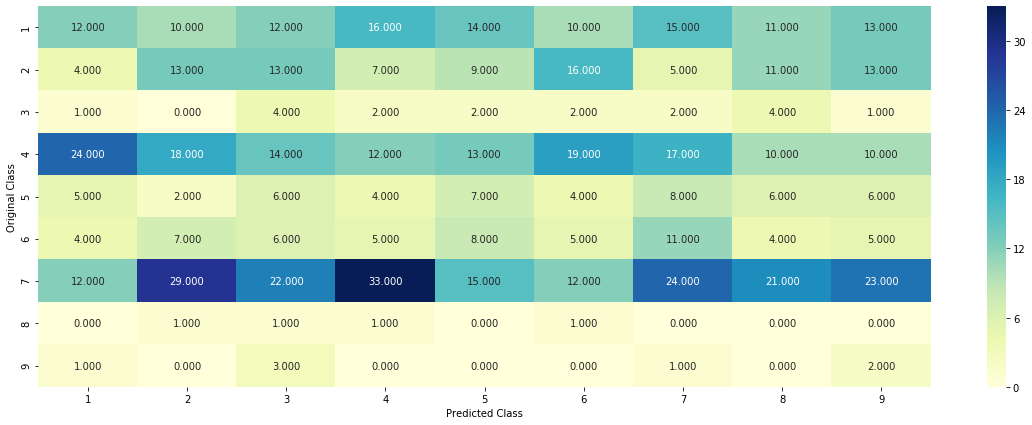

-------------------- Precision matrix (Columm Sum=1) --------------------


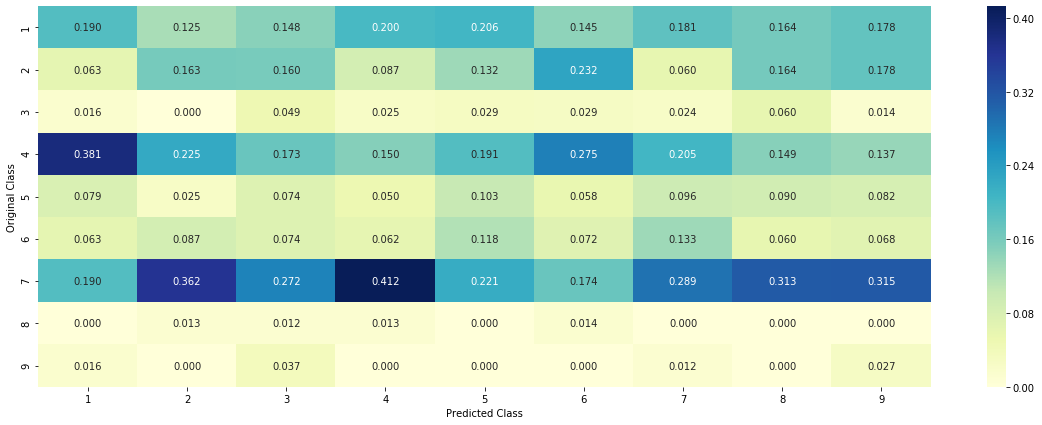

-------------------- Recall matrix (Row sum=1) --------------------


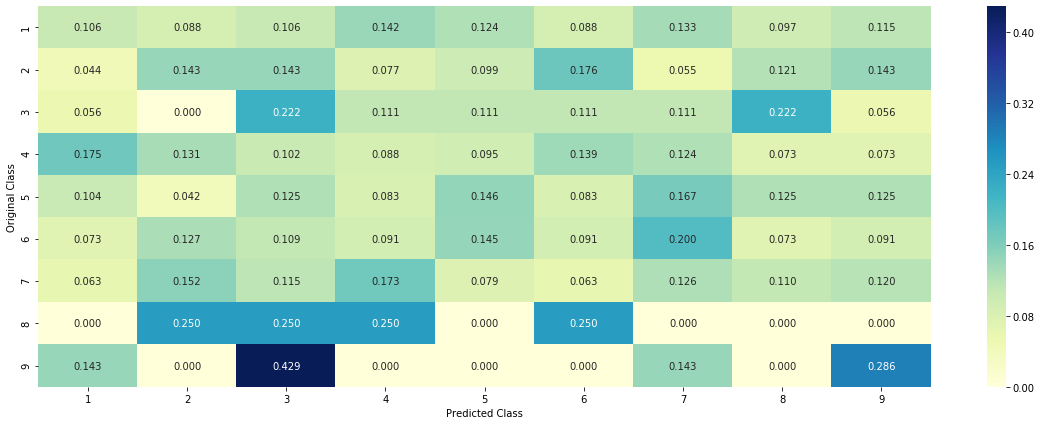

In [35]:
# we need to generate 9 numbers and the sum of numbers should be 1
# one solution is to genarate 9 numbers and divide each of the numbers by their sum
# ref: https://stackoverflow.com/a/18662466/4084039
test_data_len = test_df.shape[0]
cv_data_len = cv_df.shape[0]

# we create a output array that has exactly same size as the CV data
cv_predicted_y = np.zeros((cv_data_len,9))
for i in range(cv_data_len):
    rand_probs = np.random.rand(1,9)
    cv_predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on Cross Validation Data using Random Model",log_loss(y_cv,cv_predicted_y, eps=1e-15))


# Test-Set error.
#we create a output array that has exactly same as the test data
test_predicted_y = np.zeros((test_data_len,9))
for i in range(test_data_len):
    rand_probs = np.random.rand(1,9)
    test_predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on Test Data using Random Model",log_loss(y_test,test_predicted_y, eps=1e-15))

predicted_y =np.argmax(test_predicted_y, axis=1)
plot_confusion_matrix(y_test, predicted_y+1)

In [36]:
#UNIVARIATE ANALYSIS ON GENE FEATURE.

In [37]:
unique_genes = train_df['Gene'].value_counts()

In [38]:
unique_genes.shape[0]

233

In [39]:
print(unique_genes.head(10))

BRCA1     167
TP53      110
EGFR       89
BRCA2      82
PTEN       77
KIT        63
BRAF       56
ALK        49
ERBB2      44
PIK3CA     36
Name: Gene, dtype: int64


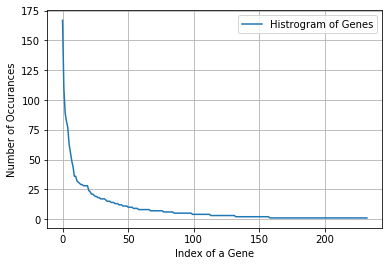

In [40]:
s = sum(unique_genes.values);
h = unique_genes.values;
plt.plot(h, label="Histrogram of Genes")
plt.xlabel('Index of a Gene')
plt.ylabel('Number of Occurances')
plt.legend()
plt.grid()
plt.show()

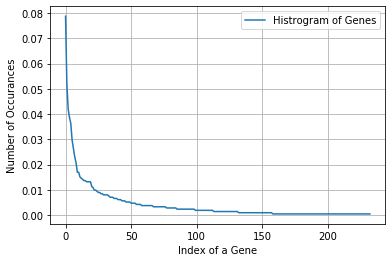

In [41]:
s_2 = sum(unique_genes.values);
h_2 = unique_genes.values/s;
plt.plot(h_2, label="Histrogram of Genes")
plt.xlabel('Index of a Gene')
plt.ylabel('Number of Occurances')
plt.legend()
plt.grid()
plt.show()

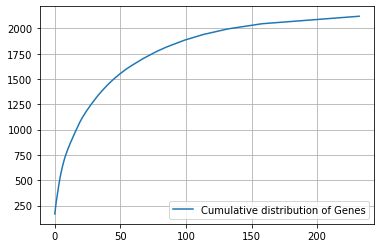

In [42]:
c = np.cumsum(h)
plt.plot(c,label='Cumulative distribution of Genes')
plt.grid()
plt.legend()
plt.show()

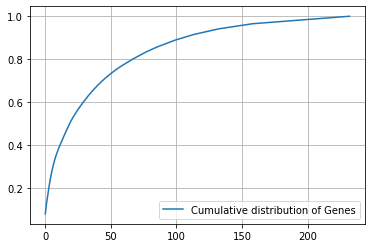

In [43]:
c = np.cumsum(h_2)
plt.plot(c,label='Cumulative distribution of Genes')
plt.grid()
plt.legend()
plt.show()

In [44]:
# code for response coding with Laplace smoothing.
# alpha : used for laplace smoothing
# feature: ['gene', 'variation']
# df: ['train_df', 'test_df', 'cv_df']
# algorithm
# ----------
# Consider all unique values and the number of occurances of given feature in train data dataframe
# build a vector (1*9) , the first element = (number of times it occured in class1 + 10*alpha / number of time it occurred in total data+90*alpha)
# gv_dict is like a look up table, for every gene it store a (1*9) representation of it
# for a value of feature in df:
# if it is in train data:
# we add the vector that was stored in 'gv_dict' look up table to 'gv_fea'
# if it is not there is train:
# we add [1/9, 1/9, 1/9, 1/9,1/9, 1/9, 1/9, 1/9, 1/9] to 'gv_fea'
# return 'gv_fea'
# ----------------------

# get_gv_fea_dict: Get Gene varaition Feature Dict
def get_gv_fea_dict(alpha, feature, df):
    # value_count: it contains a dict like
    # print(train_df['Gene'].value_counts())
    # output:
    #        {BRCA1      174
    #         TP53       106
    #         EGFR        86
    #         BRCA2       75
    #         PTEN        69
    #         KIT         61
    #         BRAF        60
    #         ERBB2       47
    #         PDGFRA      46
    #         ...}
    # print(train_df['Variation'].value_counts())
    # output:
    # {
    # Truncating_Mutations                     63
    # Deletion                                 43
    # Amplification                            43
    # Fusions                                  22
    # Overexpression                            3
    # E17K                                      3
    # Q61L                                      3
    # S222D                                     2
    # P130S                                     2
    # ...
    # }
    value_count = train_df[feature].value_counts()
    
    # gv_dict : Gene Variation Dict, which contains the probability array for each gene/variation
    gv_dict = dict()
    
    # denominator will contain the number of time that particular feature occured in whole data
    for i, denominator in value_count.items():
        # vec will contain (p(yi==1/Gi) probability of gene/variation belongs to perticular class
        # vec is 9 diamensional vector
        vec = []
        for k in range(1,10):
            # print(train_df.loc[(train_df['Class']==1) & (train_df['Gene']=='BRCA1')])
            #         ID   Gene             Variation  Class  
            # 2470  2470  BRCA1                S1715C      1   
            # 2486  2486  BRCA1                S1841R      1   
            # 2614  2614  BRCA1                   M1R      1   
            # 2432  2432  BRCA1                L1657P      1   
            # 2567  2567  BRCA1                T1685A      1   
            # 2583  2583  BRCA1                E1660G      1   
            # 2634  2634  BRCA1                W1718L      1   
            # cls_cnt.shape[0] will return the number of rows

            cls_cnt = train_df.loc[(train_df['Class']==k) & (train_df[feature]==i)]
            
            # cls_cnt.shape[0](numerator) will contain the number of time that particular feature occured in whole data
            vec.append((cls_cnt.shape[0] + alpha*10)/ (denominator + 90*alpha))

        # we are adding the gene/variation to the dict as key and vec as value
        gv_dict[i]=vec
    return gv_dict

# Get Gene variation feature
def get_gv_feature(alpha, feature, df):
    # print(gv_dict)
    #     {'BRCA1': [0.20075757575757575, 0.03787878787878788, 0.068181818181818177, 0.13636363636363635, 0.25, 0.19318181818181818, 0.03787878787878788, 0.03787878787878788, 0.03787878787878788], 
    #      'TP53': [0.32142857142857145, 0.061224489795918366, 0.061224489795918366, 0.27040816326530615, 0.061224489795918366, 0.066326530612244902, 0.051020408163265307, 0.051020408163265307, 0.056122448979591837], 
    #      'EGFR': [0.056818181818181816, 0.21590909090909091, 0.0625, 0.068181818181818177, 0.068181818181818177, 0.0625, 0.34659090909090912, 0.0625, 0.056818181818181816], 
    #      'BRCA2': [0.13333333333333333, 0.060606060606060608, 0.060606060606060608, 0.078787878787878782, 0.1393939393939394, 0.34545454545454546, 0.060606060606060608, 0.060606060606060608, 0.060606060606060608], 
    #      'PTEN': [0.069182389937106917, 0.062893081761006289, 0.069182389937106917, 0.46540880503144655, 0.075471698113207544, 0.062893081761006289, 0.069182389937106917, 0.062893081761006289, 0.062893081761006289], 
    #      'KIT': [0.066225165562913912, 0.25165562913907286, 0.072847682119205295, 0.072847682119205295, 0.066225165562913912, 0.066225165562913912, 0.27152317880794702, 0.066225165562913912, 0.066225165562913912], 
    #      'BRAF': [0.066666666666666666, 0.17999999999999999, 0.073333333333333334, 0.073333333333333334, 0.093333333333333338, 0.080000000000000002, 0.29999999999999999, 0.066666666666666666, 0.066666666666666666],
    #      ...
    #     }
    gv_dict = get_gv_fea_dict(alpha, feature, df)
    # value_count is similar in get_gv_fea_dict
    value_count = train_df[feature].value_counts()
    
    # gv_fea: Gene_variation feature, it will contain the feature for each feature value in the data
    gv_fea = []
    # for every feature values in the given data frame we will check if it is there in the train data then we will add the feature to gv_fea
    # if not we will add [1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9] to gv_fea
    for index, row in df.iterrows():
        if row[feature] in dict(value_count).keys():
            gv_fea.append(gv_dict[row[feature]])
        else:
            gv_fea.append([1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9])
#             gv_fea.append([-1,-1,-1,-1,-1,-1,-1,-1,-1])
    return gv_fea

In [45]:
#response-coding of the Gene feature
# alpha is used for laplace smoothing
alpha = 1
# train gene feature
train_gene_feature_responseCoding = np.array(get_gv_feature(alpha, "Gene", train_df))
# test gene feature
test_gene_feature_responseCoding = np.array(get_gv_feature(alpha, "Gene", test_df))
# cross validation gene feature
cv_gene_feature_responseCoding = np.array(get_gv_feature(alpha, "Gene", cv_df))

In [46]:
print("train_gene_feature_responseCoding is converted feature using respone coding method. The shape of gene feature:", train_gene_feature_responseCoding.shape)

train_gene_feature_responseCoding is converted feature using respone coding method. The shape of gene feature: (2121, 9)


In [47]:
# one-hot encoding of Gene feature.
gene_vectorizer = CountVectorizer()
train_gene_feature_onehotCoding = gene_vectorizer.fit_transform(train_df['Gene'])
test_gene_feature_onehotCoding = gene_vectorizer.transform(test_df['Gene'])
cv_gene_feature_onehotCoding = gene_vectorizer.transform(cv_df['Gene'])

In [48]:
train_df['Gene'].head()

2791     BRCA2
54       PTPRT
1246    PIK3R1
2455     BRCA1
444       TP53
Name: Gene, dtype: object

In [49]:
gene_vectorizer.get_feature_names()

['abl1',
 'acvr1',
 'ago2',
 'akt1',
 'akt2',
 'akt3',
 'alk',
 'apc',
 'ar',
 'araf',
 'arid1a',
 'arid1b',
 'arid2',
 'asxl1',
 'atm',
 'atrx',
 'aurka',
 'aurkb',
 'axl',
 'b2m',
 'bap1',
 'bcl10',
 'bcl2',
 'bcl2l11',
 'bcor',
 'braf',
 'brca1',
 'brca2',
 'brip1',
 'btk',
 'card11',
 'carm1',
 'casp8',
 'cbl',
 'ccnd1',
 'ccnd2',
 'ccnd3',
 'ccne1',
 'cdh1',
 'cdk12',
 'cdk4',
 'cdk6',
 'cdkn1a',
 'cdkn1b',
 'cdkn2a',
 'cdkn2b',
 'cdkn2c',
 'chek2',
 'cic',
 'crebbp',
 'ctcf',
 'ctla4',
 'ctnnb1',
 'ddr2',
 'dicer1',
 'dnmt3a',
 'dnmt3b',
 'egfr',
 'elf3',
 'ep300',
 'epas1',
 'epcam',
 'erbb2',
 'erbb3',
 'erbb4',
 'ercc2',
 'ercc3',
 'ercc4',
 'erg',
 'esr1',
 'etv1',
 'etv6',
 'ewsr1',
 'ezh2',
 'fam58a',
 'fanca',
 'fancc',
 'fat1',
 'fbxw7',
 'fgf4',
 'fgfr1',
 'fgfr2',
 'fgfr3',
 'fgfr4',
 'flt3',
 'foxa1',
 'foxl2',
 'foxp1',
 'fubp1',
 'gata3',
 'gnaq',
 'gnas',
 'h3f3a',
 'hist1h1c',
 'hla',
 'hnf1a',
 'hras',
 'idh1',
 'idh2',
 'igf1r',
 'ikbke',
 'il7r',
 'jak1',
 'jak2

In [50]:
print("train_gene_feature_onehotCoding is converted feature using one-hot encoding method. The shape of gene feature:", train_gene_feature_onehotCoding.shape)

train_gene_feature_onehotCoding is converted feature using one-hot encoding method. The shape of gene feature: (2121, 232)


For values of alpha =  1e-05 The log loss is: 1.210131031895688
For values of alpha =  0.0001 The log loss is: 1.1734451904137388
For values of alpha =  0.001 The log loss is: 1.2083150005018122
For values of alpha =  0.01 The log loss is: 1.3220691702901652
For values of alpha =  0.1 The log loss is: 1.4278909899256171
For values of alpha =  1 The log loss is: 1.466114185341495


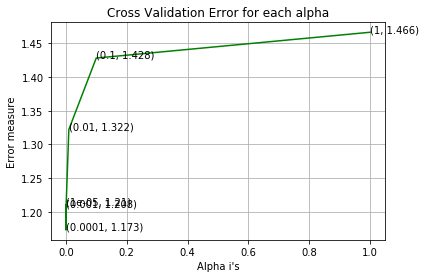

For values of best alpha =  0.0001 The train log loss is: 1.035546343279265
For values of best alpha =  0.0001 The cross validation log loss is: 1.1734451904137388
For values of best alpha =  0.0001 The test log loss is: 1.1599599823547972


In [51]:
#logistic regression on gene feature
alpha = [10 ** x for x in range(-5, 1)] # hyperparam for SGD classifier.

# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

#-------------------------------
# video link: 
#------------------------------


cv_log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_gene_feature_onehotCoding, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_gene_feature_onehotCoding, y_train)
    predict_y = sig_clf.predict_proba(cv_gene_feature_onehotCoding)
    cv_log_error_array.append(log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_gene_feature_onehotCoding, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_gene_feature_onehotCoding, y_train)

predict_y = sig_clf.predict_proba(train_gene_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_gene_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_gene_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))


In [52]:
print("Q6. How many data points in Test and CV datasets are covered by the ", unique_genes.shape[0], " genes in train dataset?")

test_coverage=test_df[test_df['Gene'].isin(list(set(train_df['Gene'])))].shape[0]
cv_coverage=cv_df[cv_df['Gene'].isin(list(set(train_df['Gene'])))].shape[0]

print('Ans\n1. In test data',test_coverage, 'out of',test_df.shape[0], ":",(test_coverage/test_df.shape[0])*100)
print('2. In cross validation data',cv_coverage, 'out of ',cv_df.shape[0],":" ,(cv_coverage/cv_df.shape[0])*100)

Q6. How many data points in Test and CV datasets are covered by the  233  genes in train dataset?
Ans
1. In test data 648 out of 664 : 97.59036144578313
2. In cross validation data 516 out of  531 : 97.17514124293785


In [53]:
#univariate analysis on variation

In [54]:
unique_variations = train_df['Variation'].value_counts()
print('Number of Unique Variations :', unique_variations.shape[0])
# the top 10 variations that occured most
print(unique_variations.head(10))

Number of Unique Variations : 1949
Truncating_Mutations    52
Amplification           39
Deletion                37
Fusions                 22
Overexpression           4
Q61L                     3
G12V                     3
T58I                     2
T167A                    2
Q61R                     2
Name: Variation, dtype: int64


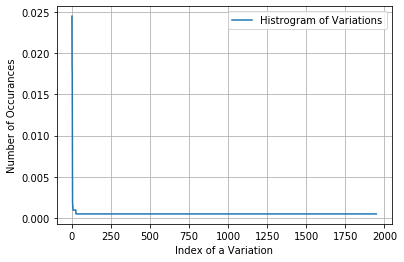

In [55]:
s = sum(unique_variations.values);
h = unique_variations.values/s;
plt.plot(h, label="Histrogram of Variations")
plt.xlabel('Index of a Variation')
plt.ylabel('Number of Occurances')
plt.legend()
plt.grid()
plt.show()

[0.02451674 0.04290429 0.06034889 ... 0.99905705 0.99952852 1.        ]


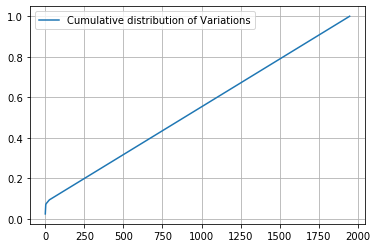

In [56]:
c = np.cumsum(h)
print(c)
plt.plot(c,label='Cumulative distribution of Variations')
plt.grid()
plt.legend()
plt.show()

In [57]:
#featurising variation feature

In [58]:
# alpha is used for laplace smoothing
alpha = 1
# train gene feature
train_variation_feature_responseCoding = np.array(get_gv_feature(alpha, "Variation", train_df))
# test gene feature
test_variation_feature_responseCoding = np.array(get_gv_feature(alpha, "Variation", test_df))
# cross validation gene feature
cv_variation_feature_responseCoding = np.array(get_gv_feature(alpha, "Variation", cv_df))

In [59]:
print("train_variation_feature_responseCoding is a converted feature using the response coding method. The shape of Variation feature:", train_variation_feature_responseCoding.shape)

train_variation_feature_responseCoding is a converted feature using the response coding method. The shape of Variation feature: (2121, 9)


In [60]:
# one-hot encoding of variation feature.
variation_vectorizer = CountVectorizer()
train_variation_feature_onehotCoding = variation_vectorizer.fit_transform(train_df['Variation'])
test_variation_feature_onehotCoding = variation_vectorizer.transform(test_df['Variation'])
cv_variation_feature_onehotCoding = variation_vectorizer.transform(cv_df['Variation'])

In [61]:
print("train_variation_feature_onehotEncoded is converted feature using the onne-hot encoding method. The shape of Variation feature:", train_variation_feature_onehotCoding.shape)

train_variation_feature_onehotEncoded is converted feature using the onne-hot encoding method. The shape of Variation feature: (2121, 1980)


For values of alpha =  1e-05 The log loss is: 1.6857230135851087
For values of alpha =  0.0001 The log loss is: 1.677896616480681
For values of alpha =  0.001 The log loss is: 1.6816036851216223
For values of alpha =  0.01 The log loss is: 1.700487974782192
For values of alpha =  0.1 The log loss is: 1.7192536690960571
For values of alpha =  1 The log loss is: 1.720885316635329


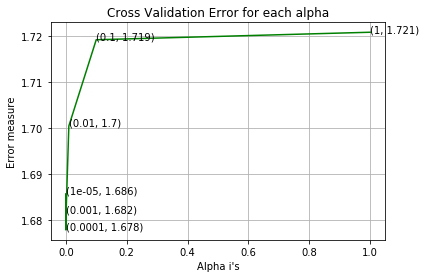

For values of best alpha =  0.0001 The train log loss is: 0.7539367323167707
For values of best alpha =  0.0001 The cross validation log loss is: 1.677896616480681
For values of best alpha =  0.0001 The test log loss is: 1.6939285035046825


In [62]:
alpha = [10 ** x for x in range(-5, 1)]

# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

#-------------------------------
# video link: 
#------------------------------


cv_log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_variation_feature_onehotCoding, y_train)
    
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_variation_feature_onehotCoding, y_train)
    predict_y = sig_clf.predict_proba(cv_variation_feature_onehotCoding)
    
    cv_log_error_array.append(log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_variation_feature_onehotCoding, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_variation_feature_onehotCoding, y_train)

predict_y = sig_clf.predict_proba(train_variation_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_variation_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_variation_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))


In [63]:
print("Q12. How many data points are covered by total ", unique_variations.shape[0], " genes in test and cross validation data sets?")
test_coverage=test_df[test_df['Variation'].isin(list(set(train_df['Variation'])))].shape[0]
cv_coverage=cv_df[cv_df['Variation'].isin(list(set(train_df['Variation'])))].shape[0]
print('Ans\n1. In test data',test_coverage, 'out of',test_df.shape[0], ":",(test_coverage/test_df.shape[0])*100)
print('2. In cross validation data',cv_coverage, 'out of ',cv_df.shape[0],":" ,(cv_coverage/cv_df.shape[0])*100)

Q12. How many data points are covered by total  1949  genes in test and cross validation data sets?
Ans
1. In test data 76 out of 664 : 11.44578313253012
2. In cross validation data 72 out of  531 : 13.559322033898304


In [64]:
#univariate analysis on text feature

In [65]:
# cls_text is a data frame
# for every row in data fram consider the 'TEXT'
# split the words by space
# make a dict with those words
# increment its count whenever we see that word

def extract_dictionary_paddle(cls_text):
    dictionary = defaultdict(int)
    for index, row in cls_text.iterrows():
        for word in row['TEXT'].split():
            dictionary[word] +=1
    return dictionary

In [66]:
import math
#https://stackoverflow.com/a/1602964
def get_text_responsecoding(df):
    text_feature_responseCoding = np.zeros((df.shape[0],9))
    for i in range(0,9):
        row_index = 0
        for index, row in df.iterrows():
            sum_prob = 0
            for word in row['TEXT'].split():
                sum_prob += math.log(((dict_list[i].get(word,0)+10 )/(total_dict.get(word,0)+90)))
            text_feature_responseCoding[row_index][i] = math.exp(sum_prob/len(row['TEXT'].split()))
            row_index += 1
    return text_feature_responseCoding

In [67]:
# building a CountVectorizer with all the words that occured minimum 3 times in train data
text_vectorizer = CountVectorizer(min_df=3)
train_text_feature_onehotCoding = text_vectorizer.fit_transform(train_df['TEXT'].values.astype('U'))
# getting all the feature names (words)
train_text_features= text_vectorizer.get_feature_names()

# train_text_feature_onehotCoding.sum(axis=0).A1 will sum every row and returns (1*number of features) vector
train_text_fea_counts = train_text_feature_onehotCoding.sum(axis=0).A1

# zip(list(text_features),text_fea_counts) will zip a word with its number of times it occured
text_fea_dict = dict(zip(list(train_text_features),train_text_fea_counts))


print("Total number of unique words in train data :", len(train_text_features))

Total number of unique words in train data : 53858


In [68]:
dict_list = []
# dict_list =[] contains 9 dictoinaries each corresponds to a class
for i in range(1,10):
    cls_text = train_df[train_df['Class']==i]
    # build a word dict based on the words in that class
    dict_list.append(extract_dictionary_paddle(cls_text))
    # append it to dict_list

# dict_list[i] is build on i'th  class text data
# total_dict is buid on whole training text data
total_dict = extract_dictionary_paddle(train_df)


confuse_array = []
for i in train_text_features:
    ratios = []
    max_val = -1
    for j in range(0,9):
        ratios.append((dict_list[j][i]+10 )/(total_dict[i]+90))
    confuse_array.append(ratios)
confuse_array = np.array(confuse_array)

In [69]:
#response coding of text features
train_text_feature_responseCoding  = get_text_responsecoding(train_df)
test_text_feature_responseCoding  = get_text_responsecoding(test_df)
cv_text_feature_responseCoding  = get_text_responsecoding(cv_df)

In [70]:
# https://stackoverflow.com/a/16202486
# we convert each row values such that they sum to 1  
train_text_feature_responseCoding = (train_text_feature_responseCoding.T/train_text_feature_responseCoding.sum(axis=1)).T
test_text_feature_responseCoding = (test_text_feature_responseCoding.T/test_text_feature_responseCoding.sum(axis=1)).T
cv_text_feature_responseCoding = (cv_text_feature_responseCoding.T/cv_text_feature_responseCoding.sum(axis=1)).T

In [71]:
# don't forget to normalize every feature
train_text_feature_onehotCoding = normalize(train_text_feature_onehotCoding, axis=0)

# we use the same vectorizer that was trained on train data
test_text_feature_onehotCoding = text_vectorizer.transform(test_df['TEXT'])
# don't forget to normalize every feature
test_text_feature_onehotCoding = normalize(test_text_feature_onehotCoding, axis=0)

# we use the same vectorizer that was trained on train data
cv_text_feature_onehotCoding = text_vectorizer.transform(cv_df['TEXT'])
# don't forget to normalize every feature
cv_text_feature_onehotCoding = normalize(cv_text_feature_onehotCoding, axis=0)

In [72]:
#https://stackoverflow.com/a/2258273/4084039
sorted_text_fea_dict = dict(sorted(text_fea_dict.items(), key=lambda x: x[1] , reverse=True))
sorted_text_occur = np.array(list(sorted_text_fea_dict.values()))

In [73]:
# Number of words for a given frequency.
print(Counter(sorted_text_occur))

Counter({3: 5437, 4: 4028, 5: 2856, 6: 2750, 7: 2376, 8: 2034, 10: 1651, 9: 1603, 11: 1337, 12: 1162, 13: 960, 14: 903, 16: 896, 15: 794, 18: 690, 21: 627, 17: 612, 20: 593, 24: 518, 22: 476, 19: 476, 23: 416, 40: 378, 27: 357, 28: 342, 25: 335, 26: 332, 30: 324, 33: 294, 31: 292, 32: 291, 36: 275, 34: 266, 29: 264, 53: 263, 35: 247, 42: 233, 39: 221, 37: 218, 43: 197, 45: 195, 41: 183, 48: 168, 54: 166, 44: 162, 55: 161, 46: 160, 50: 156, 38: 156, 49: 151, 47: 150, 52: 144, 51: 143, 56: 142, 57: 140, 59: 124, 70: 123, 63: 117, 78: 111, 67: 111, 65: 111, 58: 110, 72: 109, 62: 108, 64: 100, 61: 100, 68: 99, 60: 98, 69: 96, 66: 95, 85: 91, 74: 87, 77: 85, 81: 84, 80: 81, 84: 75, 93: 73, 79: 73, 89: 72, 83: 72, 104: 70, 75: 67, 76: 66, 71: 66, 90: 65, 87: 65, 86: 65, 82: 64, 103: 63, 92: 63, 73: 63, 99: 62, 100: 58, 88: 58, 96: 56, 105: 55, 91: 55, 120: 53, 112: 53, 107: 53, 106: 53, 122: 51, 110: 51, 126: 50, 117: 50, 98: 49, 95: 49, 119: 47, 114: 47, 101: 47, 94: 47, 108: 46, 121: 45, 1

For values of alpha =  1e-05 The log loss is: 1.368058308106834
For values of alpha =  0.0001 The log loss is: 1.1935519129007874
For values of alpha =  0.001 The log loss is: 1.185987997413234
For values of alpha =  0.01 The log loss is: 1.2982442831044305
For values of alpha =  0.1 The log loss is: 1.4819834435411106
For values of alpha =  1 The log loss is: 1.6785582841727302


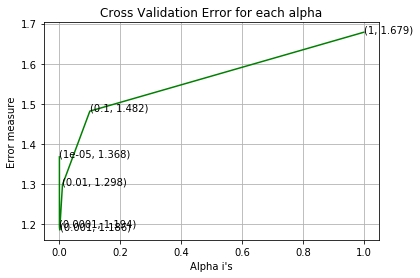

For values of best alpha =  0.001 The train log loss is: 0.7116854471498568
For values of best alpha =  0.001 The cross validation log loss is: 1.185987997413234
For values of best alpha =  0.001 The test log loss is: 1.2049015022814085


In [74]:
# Train a Logistic regression+Calibration model using text features whicha re on-hot encoded
alpha = [10 ** x for x in range(-5, 1)]

# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

#-------------------------------
# video link: 
#------------------------------


cv_log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_text_feature_onehotCoding, y_train)
    
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_text_feature_onehotCoding, y_train)
    predict_y = sig_clf.predict_proba(cv_text_feature_onehotCoding)
    cv_log_error_array.append(log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_text_feature_onehotCoding, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_text_feature_onehotCoding, y_train)

predict_y = sig_clf.predict_proba(train_text_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_text_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_text_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))


In [75]:
def get_intersec_text(df):
    df_text_vec = CountVectorizer(min_df=3)
    df_text_fea = df_text_vec.fit_transform(df['TEXT'])
    df_text_features = df_text_vec.get_feature_names()

    df_text_fea_counts = df_text_fea.sum(axis=0).A1
    df_text_fea_dict = dict(zip(list(df_text_features),df_text_fea_counts))
    len1 = len(set(df_text_features))
    len2 = len(set(train_text_features) & set(df_text_features))
    return len1,len2

In [76]:
len1,len2 = get_intersec_text(test_df)
print(np.round((len2/len1)*100, 3), "% of word of test data appeared in train data")
len1,len2 = get_intersec_text(cv_df)
print(np.round((len2/len1)*100, 3), "% of word of Cross Validation appeared in train data")

96.166 % of word of test data appeared in train data
98.454 % of word of Cross Validation appeared in train data


In [77]:
#ML MODELS


In [78]:
#Data preparation for ML models.

#Misc. functionns for ML models


def predict_and_plot_confusion_matrix(train_x, train_y,test_x, test_y, clf):
    clf.fit(train_x, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x, train_y)
    pred_y = sig_clf.predict(test_x)

    # for calculating log_loss we willl provide the array of probabilities belongs to each class
    print("Log loss :",log_loss(test_y, sig_clf.predict_proba(test_x)))
    # calculating the number of data points that are misclassified
    print("Number of mis-classified points :", np.count_nonzero((pred_y- test_y))/test_y.shape[0])
    plot_confusion_matrix(test_y, pred_y)

In [79]:
def report_log_loss(train_x, train_y, test_x, test_y,  clf):
    clf.fit(train_x, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x, train_y)
    sig_clf_probs = sig_clf.predict_proba(test_x)
    return log_loss(test_y, sig_clf_probs, eps=1e-15)

In [80]:
# this function will be used just for naive bayes
# for the given indices, we will print the name of the features
# and we will check whether the feature present in the test point text or not
def get_impfeature_names(indices, text, gene, var, no_features):
    gene_count_vec = CountVectorizer()
    var_count_vec = CountVectorizer()
    text_count_vec = CountVectorizer(min_df=3)
    
    gene_vec = gene_count_vec.fit(train_df['Gene'])
    var_vec  = var_count_vec.fit(train_df['Variation'])
    text_vec = text_count_vec.fit(train_df['TEXT'])
    
    fea1_len = len(gene_vec.get_feature_names())
    fea2_len = len(var_count_vec.get_feature_names())
    
    word_present = 0
    for i,v in enumerate(indices):
        if (v < fea1_len):
            word = gene_vec.get_feature_names()[v]
            yes_no = True if word == gene else False
            if yes_no:
                word_present += 1
                print(i, "Gene feature [{}] present in test data point [{}]".format(word,yes_no))
        elif (v < fea1_len+fea2_len):
            word = var_vec.get_feature_names()[v-(fea1_len)]
            yes_no = True if word == var else False
            if yes_no:
                word_present += 1
                print(i, "variation feature [{}] present in test data point [{}]".format(word,yes_no))
        else:
            word = text_vec.get_feature_names()[v-(fea1_len+fea2_len)]
            yes_no = True if word in text.split() else False
            if yes_no:
                word_present += 1
                print(i, "Text feature [{}] present in test data point [{}]".format(word,yes_no))

    print("Out of the top ",no_features," features ", word_present, "are present in query point")

NameError: name 'train_gene_var_responseCoding' is not defined

In [82]:
train_text_feature_responseCoding.shape

(2121, 9)

In [83]:
train_gene_feature_responseCoding.shape


(2121, 9)

In [84]:
# merging gene, variance and text features

# building train, test and cross validation data sets
# a = [[1, 2], 
#      [3, 4]]
# b = [[4, 5], 
#      [6, 7]]
# hstack(a, b) = [[1, 2, 4, 5],
#                [ 3, 4, 6, 7]]

train_gene_var_onehotCoding = hstack((train_gene_feature_onehotCoding,train_variation_feature_onehotCoding))
test_gene_var_onehotCoding = hstack((test_gene_feature_onehotCoding,test_variation_feature_onehotCoding))
cv_gene_var_onehotCoding = hstack((cv_gene_feature_onehotCoding,cv_variation_feature_onehotCoding))

train_x_onehotCoding = hstack((train_gene_var_onehotCoding, train_text_feature_onehotCoding)).tocsr()
train_y = np.array(list(train_df['Class']))

test_x_onehotCoding = hstack((test_gene_var_onehotCoding, test_text_feature_onehotCoding)).tocsr()
test_y = np.array(list(test_df['Class']))

cv_x_onehotCoding = hstack((cv_gene_var_onehotCoding, cv_text_feature_onehotCoding)).tocsr()
cv_y = np.array(list(cv_df['Class']))


train_gene_var_responseCoding = np.hstack((train_gene_feature_responseCoding,train_variation_feature_responseCoding))
test_gene_var_responseCoding = np.hstack((test_gene_feature_responseCoding,test_variation_feature_responseCoding))
cv_gene_var_responseCoding = np.hstack((cv_gene_feature_responseCoding,cv_variation_feature_responseCoding))

train_x_responseCoding = np.hstack((train_gene_var_responseCoding, train_text_feature_responseCoding))
test_x_responseCoding = np.hstack((test_gene_var_responseCoding, test_text_feature_responseCoding))
cv_x_responseCoding = np.hstack((cv_gene_var_responseCoding, cv_text_feature_responseCoding))


In [85]:
print("One hot encoding features :")
print("(number of data points * number of features) in train data = ", train_x_onehotCoding.shape)
print("(number of data points * number of features) in test data = ", test_x_onehotCoding.shape)
print("(number of data points * number of features) in cross validation data =", cv_x_onehotCoding.shape)

One hot encoding features :
(number of data points * number of features) in train data =  (2121, 56070)
(number of data points * number of features) in test data =  (664, 56070)
(number of data points * number of features) in cross validation data = (531, 56070)


In [86]:
print(" Response encoding features :")
print("(number of data points * number of features) in train data = ", train_x_responseCoding.shape)
print("(number of data points * number of features) in test data = ", test_x_responseCoding.shape)
print("(number of data points * number of features) in cross validation data =", cv_x_responseCoding.shape)

 Response encoding features :
(number of data points * number of features) in train data =  (2121, 27)
(number of data points * number of features) in test data =  (664, 27)
(number of data points * number of features) in cross validation data = (531, 27)


In [87]:
#Models

In [88]:
#baseline

In [89]:
#naive bayes

for alpha = 1e-05
Log Loss : 1.2905302030785095
for alpha = 0.0001
Log Loss : 1.279004710145604
for alpha = 0.001
Log Loss : 1.2710689393615429
for alpha = 0.1
Log Loss : 1.2303735852561897
for alpha = 1
Log Loss : 1.2869414609035057
for alpha = 10
Log Loss : 1.4267083385934693
for alpha = 100
Log Loss : 1.3617894037270417
for alpha = 1000
Log Loss : 1.3269678089648742


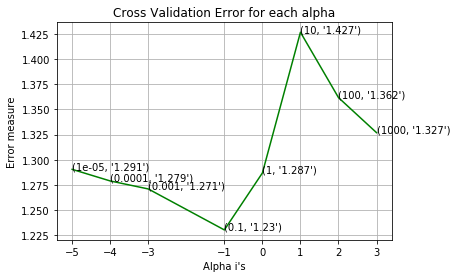

For values of best alpha =  0.1 The train log loss is: 0.9131256919009856
For values of best alpha =  0.1 The cross validation log loss is: 1.2303735852561897
For values of best alpha =  0.1 The test log loss is: 1.2853317063951006


In [90]:
# find more about Multinomial Naive base function here http://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html
# -------------------------
# default paramters
# sklearn.naive_bayes.MultinomialNB(alpha=1.0, fit_prior=True, class_prior=None)

# some of methods of MultinomialNB()
# fit(X, y[, sample_weight])	Fit Naive Bayes classifier according to X, y
# predict(X)	Perform classification on an array of test vectors X.
# predict_log_proba(X)	Return log-probability estimates for the test vector X.
# -----------------------
# video link: https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/naive-bayes-algorithm-1/
# -----------------------


# find more about CalibratedClassifierCV here at http://scikit-learn.org/stable/modules/generated/sklearn.calibration.CalibratedClassifierCV.html
# ----------------------------
# default paramters
# sklearn.calibration.CalibratedClassifierCV(base_estimator=None, method=’sigmoid’, cv=3)
#
# some of the methods of CalibratedClassifierCV()
# fit(X, y[, sample_weight])	Fit the calibrated model
# get_params([deep])	Get parameters for this estimator.
# predict(X)	Predict the target of new samples.
# predict_proba(X)	Posterior probabilities of classification
# ----------------------------
# video link: https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/naive-bayes-algorithm-1/
# -----------------------


alpha = [0.00001, 0.0001, 0.001, 0.1, 1, 10, 100,1000]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = MultinomialNB(alpha=i)
    clf.fit(train_x_onehotCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(np.log10(alpha), cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (np.log10(alpha[i]),cv_log_error_array[i]))
plt.grid()
plt.xticks(np.log10(alpha))
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = MultinomialNB(alpha=alpha[best_alpha])
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)


predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))


Log Loss : 1.2303735852561897
Number of missclassified point : 0.3785310734463277
-------------------- Confusion matrix --------------------


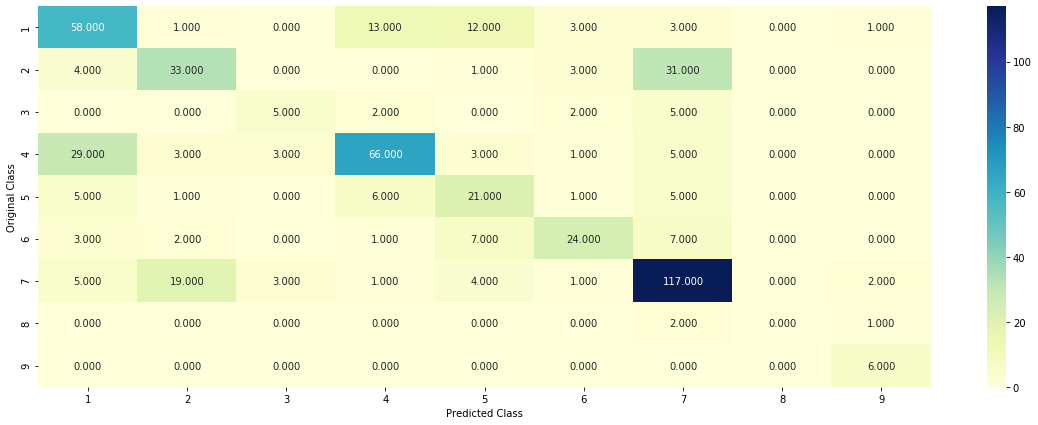

-------------------- Precision matrix (Columm Sum=1) --------------------


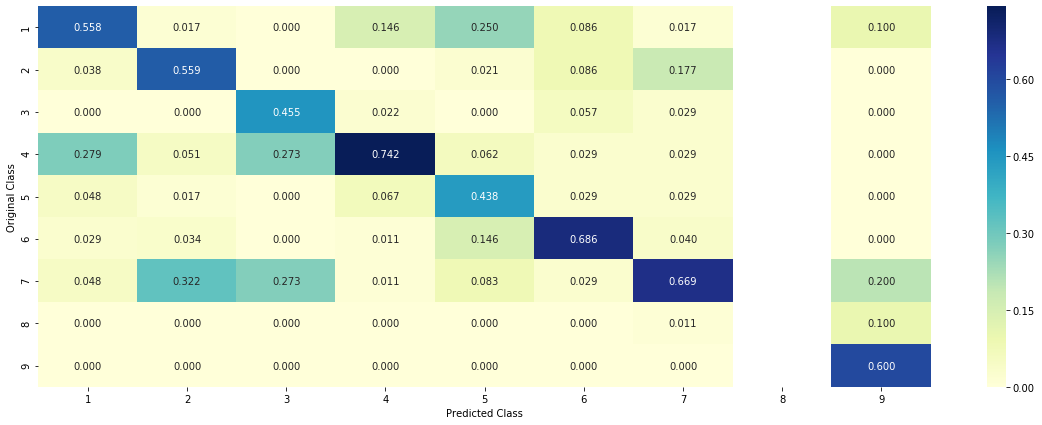

-------------------- Recall matrix (Row sum=1) --------------------


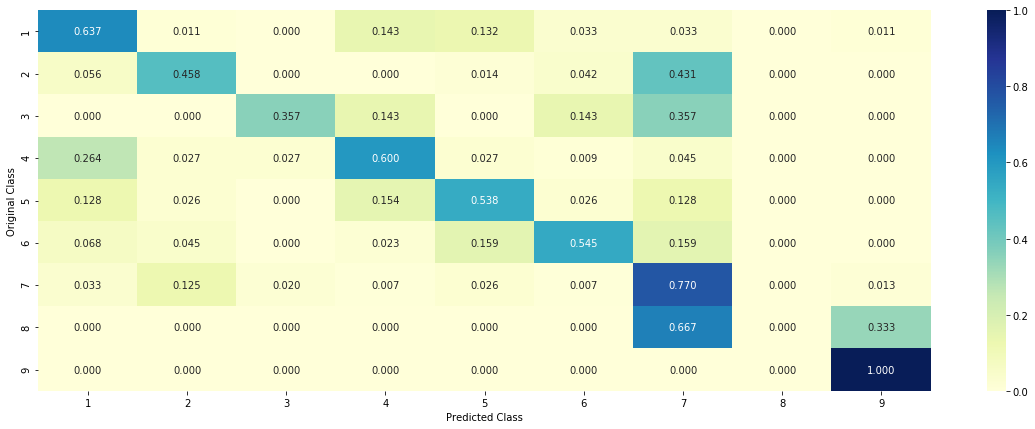

In [91]:
# find more about Multinomial Naive base function here http://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html
# -------------------------
# default paramters
# sklearn.naive_bayes.MultinomialNB(alpha=1.0, fit_prior=True, class_prior=None)

# some of methods of MultinomialNB()
# fit(X, y[, sample_weight])	Fit Naive Bayes classifier according to X, y
# predict(X)	Perform classification on an array of test vectors X.
# predict_log_proba(X)	Return log-probability estimates for the test vector X.
# -----------------------
# video link: https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/naive-bayes-algorithm-1/
# -----------------------


# find more about CalibratedClassifierCV here at http://scikit-learn.org/stable/modules/generated/sklearn.calibration.CalibratedClassifierCV.html
# ----------------------------
# default paramters
# sklearn.calibration.CalibratedClassifierCV(base_estimator=None, method=’sigmoid’, cv=3)
#
# some of the methods of CalibratedClassifierCV()
# fit(X, y[, sample_weight])	Fit the calibrated model
# get_params([deep])	Get parameters for this estimator.
# predict(X)	Predict the target of new samples.
# predict_proba(X)	Posterior probabilities of classification
# ----------------------------

clf = MultinomialNB(alpha=alpha[best_alpha])
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)
sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
# to avoid rounding error while multiplying probabilites we use log-probability estimates
print("Log Loss :",log_loss(cv_y, sig_clf_probs))
print("Number of missclassified point :", np.count_nonzero((sig_clf.predict(cv_x_onehotCoding)- cv_y))/cv_y.shape[0])
plot_confusion_matrix(cv_y, sig_clf.predict(cv_x_onehotCoding.toarray()))

In [92]:
test_point_index = 1
no_feature = 100
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.coef_)[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 2
Predicted Class Probabilities: [[0.093  0.4854 0.0142 0.1273 0.0478 0.0411 0.1806 0.0058 0.0048]]
Actual Class : 2
--------------------------------------------------
18 Text feature [identified] present in test data point [True]
19 Text feature [harbored] present in test data point [True]
21 Text feature [novel] present in test data point [True]
23 Text feature [time] present in test data point [True]
24 Text feature [detection] present in test data point [True]
25 Text feature [another] present in test data point [True]
26 Text feature [new] present in test data point [True]
27 Text feature [sequencing] present in test data point [True]
28 Text feature [confirmed] present in test data point [True]
29 Text feature [including] present in test data point [True]
30 Text feature [kinase] present in test data point [True]
31 Text feature [clinical] present in test data point [True]
32 Text feature [well] present in test data point [True]
33 Text feature [patient] present

In [93]:
#incorrect prediction
test_point_index = 100
no_feature = 100
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.coef_)[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 6
Predicted Class Probabilities: [[0.08   0.0724 0.0122 0.11   0.0414 0.5525 0.1224 0.0049 0.0042]]
Actual Class : 5
--------------------------------------------------
5 Text feature [i2285v] present in test data point [True]
6 Text feature [ivs8] present in test data point [True]
7 Text feature [brca] present in test data point [True]
8 Text feature [ivs20] present in test data point [True]
9 Text feature [ivs13] present in test data point [True]
10 Text feature [ivs5] present in test data point [True]
11 Text feature [i124v] present in test data point [True]
12 Text feature [odds] present in test data point [True]
13 Text feature [personal] present in test data point [True]
14 Text feature [57] present in test data point [True]
15 Text feature [k513r] present in test data point [True]
16 Text feature [k2950n] present in test data point [True]
17 Text feature [lrs] present in test data point [True]
18 Text feature [falling] present in test data point [True]
19 Text f

In [94]:
#KNN

for alpha = 5
Log Loss : 1.0910068870074952
for alpha = 11
Log Loss : 1.056979991108447
for alpha = 15
Log Loss : 1.060305376709046
for alpha = 21
Log Loss : 1.0632889055353896
for alpha = 31
Log Loss : 1.0585380833318858
for alpha = 41
Log Loss : 1.0679729745240873
for alpha = 51
Log Loss : 1.0747938186141037
for alpha = 99
Log Loss : 1.0791609603937549


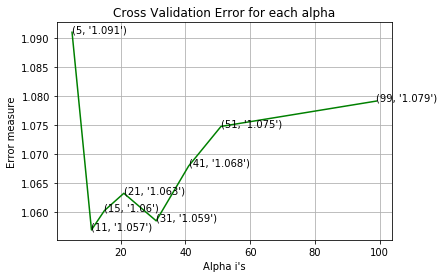

For values of best alpha =  11 The train log loss is: 0.6650930014295916
For values of best alpha =  11 The cross validation log loss is: 1.056979991108447
For values of best alpha =  11 The test log loss is: 0.9968360189866706


In [95]:
# find more about KNeighborsClassifier() here http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html
# -------------------------
# default parameter
# KNeighborsClassifier(n_neighbors=5, weights=’uniform’, algorithm=’auto’, leaf_size=30, p=2, 
# metric=’minkowski’, metric_params=None, n_jobs=1, **kwargs)

# methods of
# fit(X, y) : Fit the model using X as training data and y as target values
# predict(X):Predict the class labels for the provided data
# predict_proba(X):Return probability estimates for the test data X.
#-------------------------------------
# video link: https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/k-nearest-neighbors-geometric-intuition-with-a-toy-example-1/
#-------------------------------------


# find more about CalibratedClassifierCV here at http://scikit-learn.org/stable/modules/generated/sklearn.calibration.CalibratedClassifierCV.html
# ----------------------------
# default paramters
# sklearn.calibration.CalibratedClassifierCV(base_estimator=None, method=’sigmoid’, cv=3)
#
# some of the methods of CalibratedClassifierCV()
# fit(X, y[, sample_weight])	Fit the calibrated model
# get_params([deep])	Get parameters for this estimator.
# predict(X)	Predict the target of new samples.
# predict_proba(X)	Posterior probabilities of classification
#-------------------------------------
# video link:
#-------------------------------------


alpha = [5, 11, 15, 21, 31, 41, 51, 99]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = KNeighborsClassifier(n_neighbors=i)
    clf.fit(train_x_responseCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_responseCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_responseCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
clf.fit(train_x_responseCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_responseCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_responseCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_responseCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_responseCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))


Log loss : 1.056979991108447
Number of mis-classified points : 0.3766478342749529
-------------------- Confusion matrix --------------------


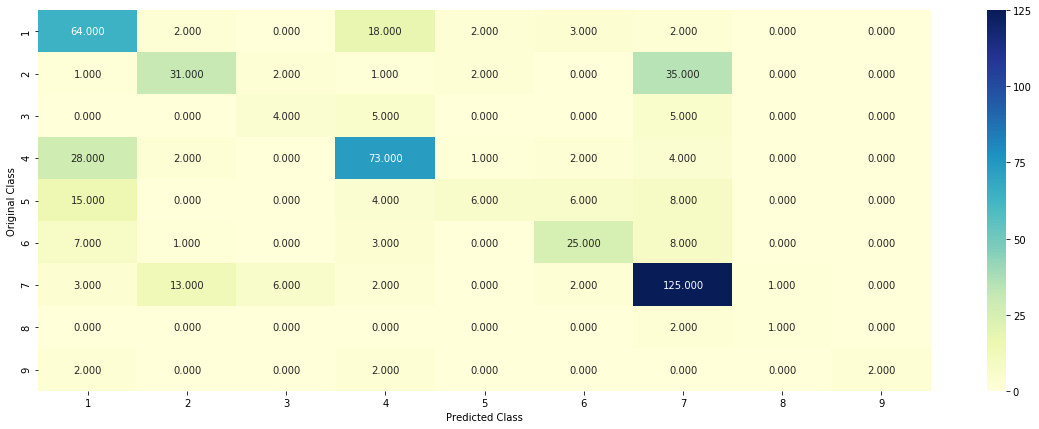

-------------------- Precision matrix (Columm Sum=1) --------------------


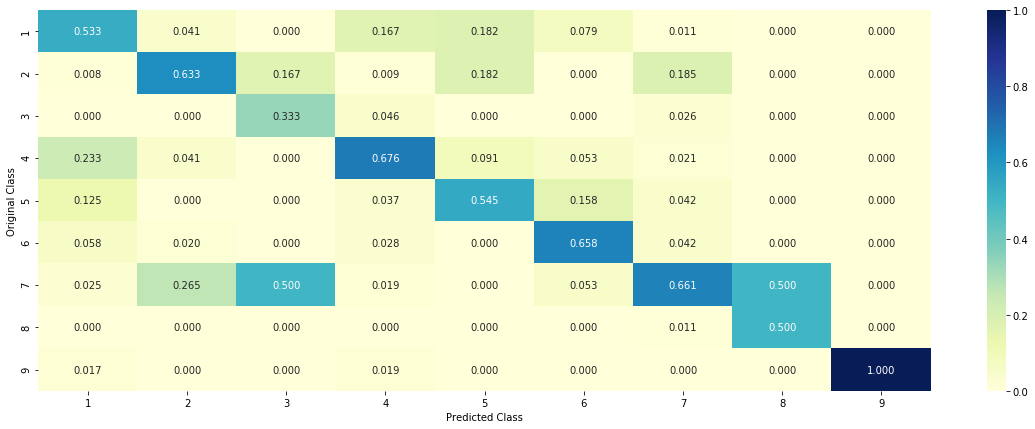

-------------------- Recall matrix (Row sum=1) --------------------


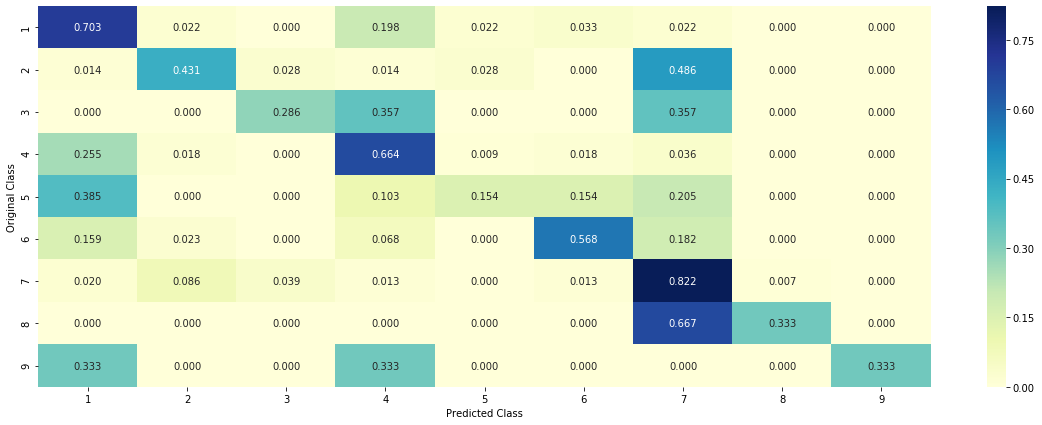

In [96]:
# find more about KNeighborsClassifier() here http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html
# -------------------------
# default parameter
# KNeighborsClassifier(n_neighbors=5, weights=’uniform’, algorithm=’auto’, leaf_size=30, p=2, 
# metric=’minkowski’, metric_params=None, n_jobs=1, **kwargs)

# methods of
# fit(X, y) : Fit the model using X as training data and y as target values
# predict(X):Predict the class labels for the provided data
# predict_proba(X):Return probability estimates for the test data X.
#-------------------------------------
# video link: https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/k-nearest-neighbors-geometric-intuition-with-a-toy-example-1/
#-------------------------------------
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
predict_and_plot_confusion_matrix(train_x_responseCoding, train_y, cv_x_responseCoding, cv_y, clf)

In [97]:
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
clf.fit(train_x_responseCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_responseCoding, train_y)

test_point_index = 1
predicted_cls = sig_clf.predict(test_x_responseCoding[0].reshape(1,-1))
print("Predicted Class :", predicted_cls[0])
print("Actual Class :", test_y[test_point_index])
neighbors = clf.kneighbors(test_x_responseCoding[test_point_index].reshape(1, -1), alpha[best_alpha])
print("The ",alpha[best_alpha]," nearest neighbours of the test points belongs to classes",train_y[neighbors[1][0]])
print("Fequency of nearest points :",Counter(train_y[neighbors[1][0]]))

Predicted Class : 1
Actual Class : 2
The  11  nearest neighbours of the test points belongs to classes [2 2 7 7 7 2 2 2 7 2 7]
Fequency of nearest points : Counter({2: 6, 7: 5})


In [98]:
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
clf.fit(train_x_responseCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_responseCoding, train_y)

test_point_index = 100

predicted_cls = sig_clf.predict(test_x_responseCoding[test_point_index].reshape(1,-1))
print("Predicted Class :", predicted_cls[0])
print("Actual Class :", test_y[test_point_index])
neighbors = clf.kneighbors(test_x_responseCoding[test_point_index].reshape(1, -1), alpha[best_alpha])
print("the k value for knn is",alpha[best_alpha],"and the nearest neighbours of the test points belongs to classes",train_y[neighbors[1][0]])
print("Fequency of nearest points :",Counter(train_y[neighbors[1][0]]))

Predicted Class : 6
Actual Class : 5
the k value for knn is 11 and the nearest neighbours of the test points belongs to classes [1 1 1 1 5 5 4 1 6 6 6]
Fequency of nearest points : Counter({1: 5, 6: 3, 5: 2, 4: 1})


Lgistic regression using class balancing

for alpha = 1e-06
Log Loss : 1.3383537851236695
for alpha = 1e-05
Log Loss : 1.3234223293650444
for alpha = 0.0001
Log Loss : 1.1656101340922949
for alpha = 0.001
Log Loss : 1.1164640483866417
for alpha = 0.01
Log Loss : 1.1718799275878975
for alpha = 0.1
Log Loss : 1.4387001126486116
for alpha = 1
Log Loss : 1.698065250933072
for alpha = 10
Log Loss : 1.7312368756741765
for alpha = 100
Log Loss : 1.7346830535290947


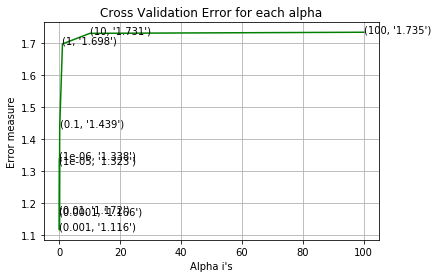

For values of best alpha =  0.001 The train log loss is: 0.5892574147857699
For values of best alpha =  0.001 The cross validation log loss is: 1.1164640483866417
For values of best alpha =  0.001 The test log loss is: 1.121246265037532


In [99]:

# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

#-------------------------------
# video link: https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/geometric-intuition-1/
#------------------------------


# find more about CalibratedClassifierCV here at http://scikit-learn.org/stable/modules/generated/sklearn.calibration.CalibratedClassifierCV.html
# ----------------------------
# default paramters
# sklearn.calibration.CalibratedClassifierCV(base_estimator=None, method=’sigmoid’, cv=3)
#
# some of the methods of CalibratedClassifierCV()
# fit(X, y[, sample_weight])	Fit the calibrated model
# get_params([deep])	Get parameters for this estimator.
# predict(X)	Predict the target of new samples.
# predict_proba(X)	Posterior probabilities of classification
#-------------------------------------
# video link:
#-------------------------------------

alpha = [10 ** x for x in range(-6, 3)]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier(class_weight='balanced', alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_x_onehotCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

Log loss : 1.1164640483866417
Number of mis-classified points : 0.3465160075329567
-------------------- Confusion matrix --------------------


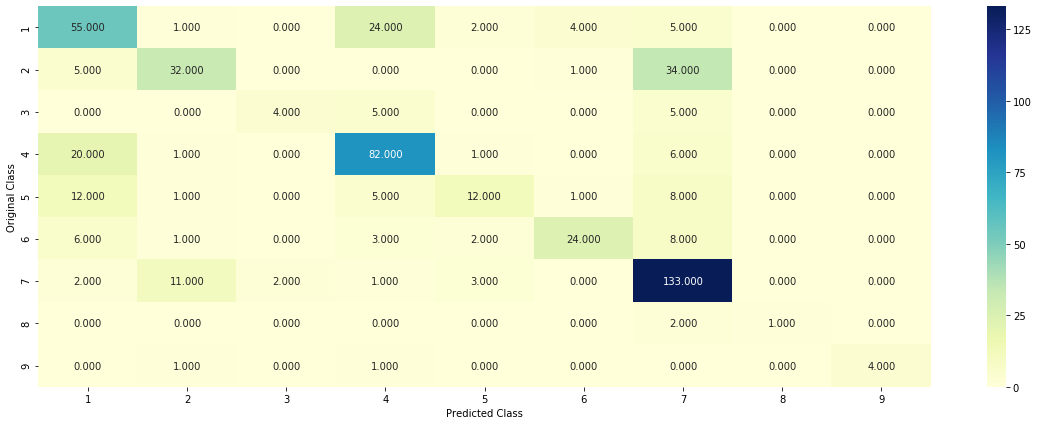

-------------------- Precision matrix (Columm Sum=1) --------------------


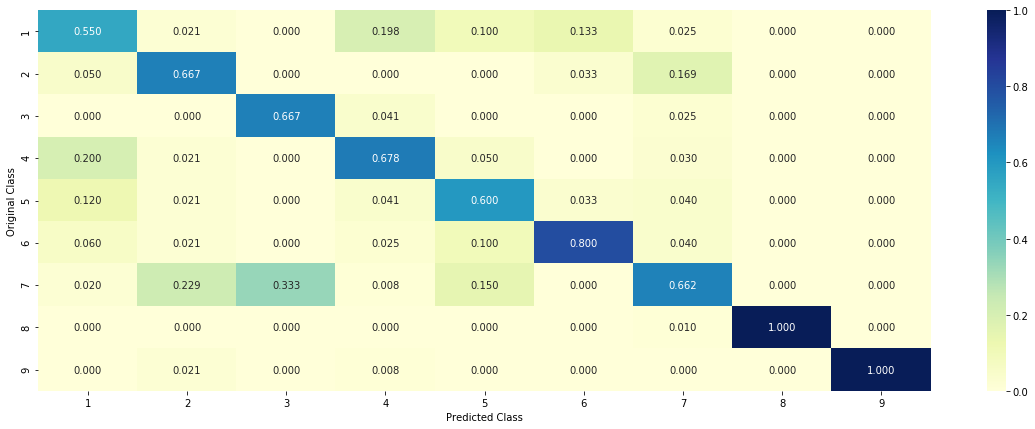

-------------------- Recall matrix (Row sum=1) --------------------


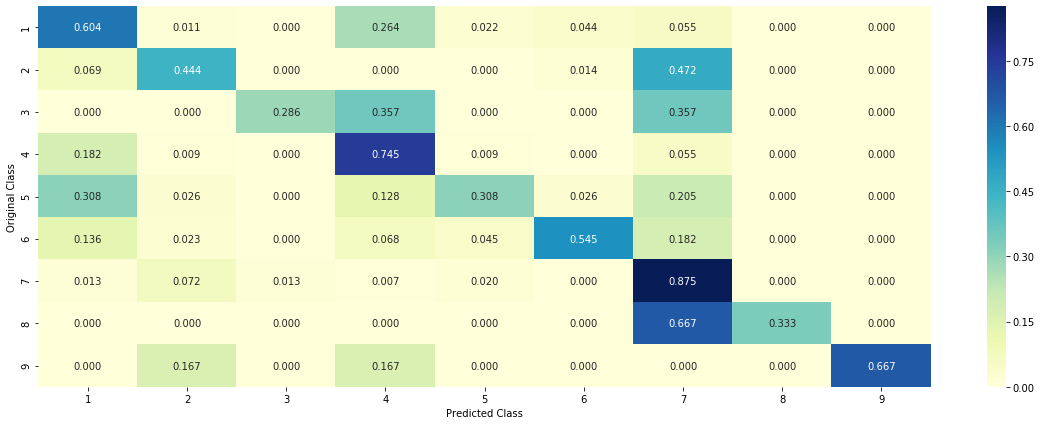

In [100]:
# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

#-------------------------------
# video link: https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/geometric-intuition-1/
#------------------------------
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
predict_and_plot_confusion_matrix(train_x_onehotCoding, train_y, cv_x_onehotCoding, cv_y, clf)

In [101]:
def get_imp_feature_names(text, indices, removed_ind = []):
    word_present = 0
    tabulte_list = []
    incresingorder_ind = 0
    for i in indices:
        if i < train_gene_feature_onehotCoding.shape[1]:
            tabulte_list.append([incresingorder_ind, "Gene", "Yes"])
        elif i< 18:
            tabulte_list.append([incresingorder_ind,"Variation", "Yes"])
        if ((i > 17) & (i not in removed_ind)) :
            word = train_text_features[i]
            yes_no = True if word in text.split() else False
            if yes_no:
                word_present += 1
            tabulte_list.append([incresingorder_ind,train_text_features[i], yes_no])
        incresingorder_ind += 1
    print(word_present, "most importent features are present in our query point")
    print("-"*50)
    print("The features that are most importent of the ",predicted_cls[0]," class:")
    print (tabulate(tabulte_list, headers=["Index",'Feature name', 'Present or Not']))

In [102]:
# from tabulate import tabulate
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_onehotCoding,train_y)
test_point_index = 1
no_feature = 500
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.coef_)[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 2
Predicted Class Probabilities: [[3.900e-03 5.437e-01 5.000e-04 2.300e-03 5.200e-03 1.400e-03 4.314e-01
  8.300e-03 3.300e-03]]
Actual Class : 2
--------------------------------------------------
140 Text feature [serpentine] present in test data point [True]
148 Text feature [md] present in test data point [True]
278 Text feature [heptahelical] present in test data point [True]
365 Text feature [d473h] present in test data point [True]
420 Text feature [medulloblastoma] present in test data point [True]
479 Text feature [finite] present in test data point [True]
Out of the top  500  features  6 are present in query point


In [103]:
test_point_index = 100
no_feature = 500
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.coef_)[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 1
Predicted Class Probabilities: [[6.074e-01 1.500e-03 1.000e-04 9.200e-03 3.644e-01 9.300e-03 1.000e-04
  5.700e-03 2.300e-03]]
Actual Class : 5
--------------------------------------------------
111 Text feature [c8] present in test data point [True]
207 Text feature [89] present in test data point [True]
222 Text feature [discriminates] present in test data point [True]
242 Text feature [k3326x] present in test data point [True]
256 Text feature [multifunctionality] present in test data point [True]
260 Text feature [exceeding] present in test data point [True]
302 Text feature [r2659t] present in test data point [True]
303 Text feature [d2723a] present in test data point [True]
304 Text feature [3531] present in test data point [True]
305 Text feature [gfpexpressing] present in test data point [True]
306 Text feature [a2643g] present in test data point [True]
307 Text feature [8http] present in test data point [True]
308 Text feature [cutpoints] present in test da

wirhout class balancing

for alpha = 1e-06
Log Loss : 1.3774548544448413
for alpha = 1e-05
Log Loss : 1.3267166649208664
for alpha = 0.0001
Log Loss : 1.1668962309606643
for alpha = 0.001
Log Loss : 1.139479765655588
for alpha = 0.01
Log Loss : 1.2301415361795351
for alpha = 0.1
Log Loss : 1.423402042584282
for alpha = 1
Log Loss : 1.6285876193878819


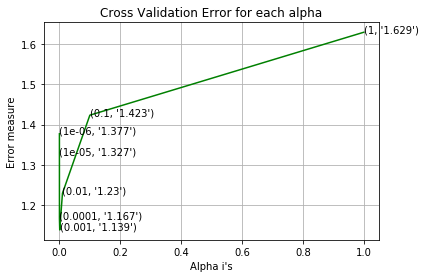

For values of best alpha =  0.001 The train log loss is: 0.5864468411541268
For values of best alpha =  0.001 The cross validation log loss is: 1.139479765655588
For values of best alpha =  0.001 The test log loss is: 1.1355763778816708


In [104]:
# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

#-------------------------------
# video link: https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/geometric-intuition-1/
#------------------------------



# find more about CalibratedClassifierCV here at http://scikit-learn.org/stable/modules/generated/sklearn.calibration.CalibratedClassifierCV.html
# ----------------------------
# default paramters
# sklearn.calibration.CalibratedClassifierCV(base_estimator=None, method=’sigmoid’, cv=3)
#
# some of the methods of CalibratedClassifierCV()
# fit(X, y[, sample_weight])	Fit the calibrated model
# get_params([deep])	Get parameters for this estimator.
# predict(X)	Predict the target of new samples.
# predict_proba(X)	Posterior probabilities of classification
#-------------------------------------
# video link:
#-------------------------------------

alpha = [10 ** x for x in range(-6, 1)]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_x_onehotCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

Log loss : 1.139479765655588
Number of mis-classified points : 0.3578154425612053
-------------------- Confusion matrix --------------------


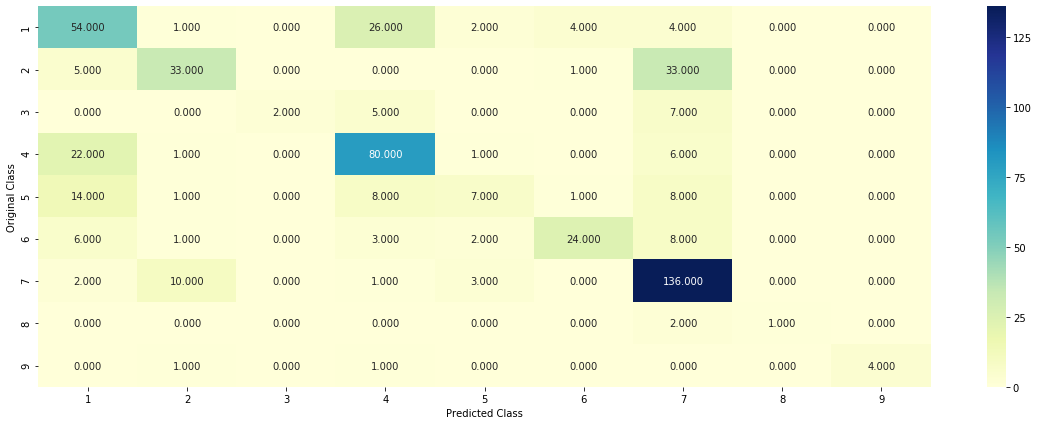

-------------------- Precision matrix (Columm Sum=1) --------------------


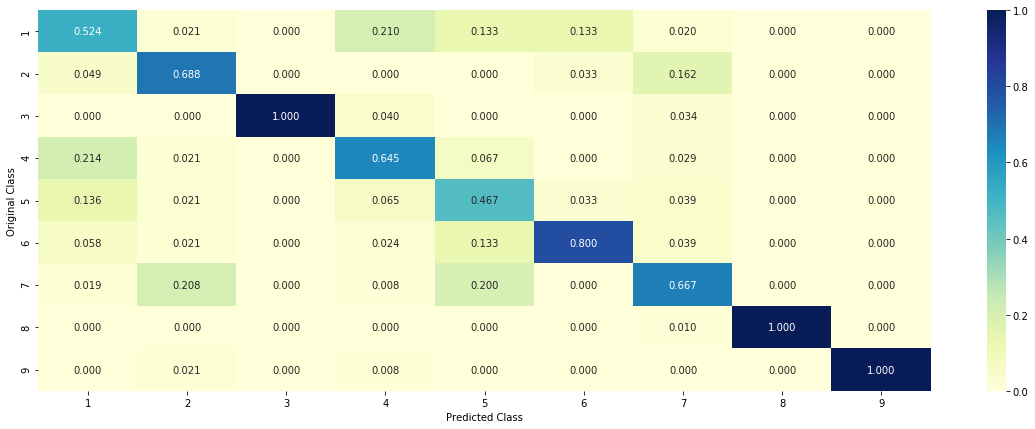

-------------------- Recall matrix (Row sum=1) --------------------


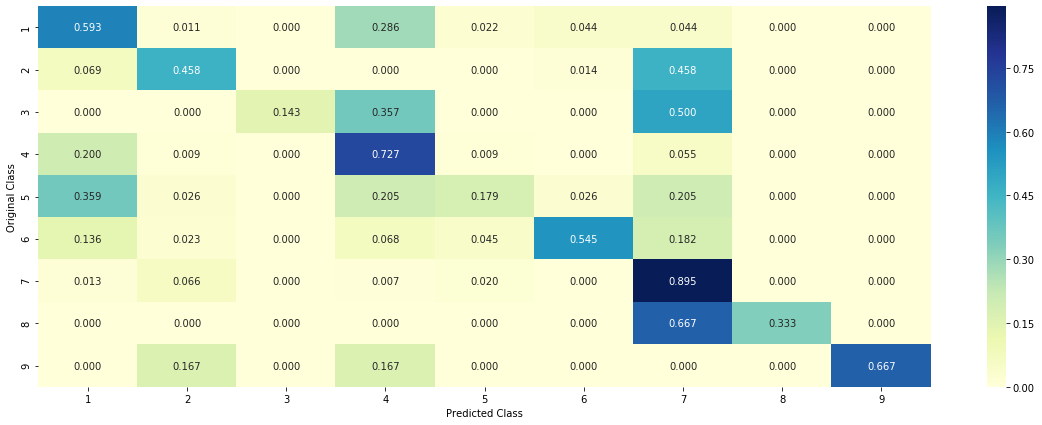

In [105]:
# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

#-------------------------------
# video link: 
#------------------------------

clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
predict_and_plot_confusion_matrix(train_x_onehotCoding, train_y, cv_x_onehotCoding, cv_y, clf)

Linear Support Vector Machines

for C = 1e-05
Log Loss : 1.321304160406459
for C = 0.0001
Log Loss : 1.2532459001319156
for C = 0.001
Log Loss : 1.1551609339971267
for C = 0.01
Log Loss : 1.1393440279682665
for C = 0.1
Log Loss : 1.3130801886442978
for C = 1
Log Loss : 1.7176826845255582
for C = 10
Log Loss : 1.7353256928313894
for C = 100
Log Loss : 1.735324895643053


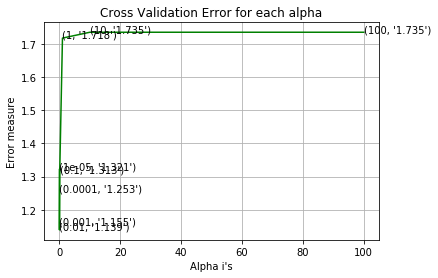

For values of best alpha =  0.01 The train log loss is: 0.7672210058237918
For values of best alpha =  0.01 The cross validation log loss is: 1.1393440279682665
For values of best alpha =  0.01 The test log loss is: 1.171300955559917


In [106]:
# read more about support vector machines with linear kernals here http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html

# --------------------------------
# default parameters 
# SVC(C=1.0, kernel=’rbf’, degree=3, gamma=’auto’, coef0=0.0, shrinking=True, probability=False, tol=0.001, 
# cache_size=200, class_weight=None, verbose=False, max_iter=-1, decision_function_shape=’ovr’, random_state=None)

# Some of methods of SVM()
# fit(X, y, [sample_weight])	Fit the SVM model according to the given training data.
# predict(X)	Perform classification on samples in X.
# --------------------------------
# video link: https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/mathematical-derivation-copy-8/
# --------------------------------



# find more about CalibratedClassifierCV here at http://scikit-learn.org/stable/modules/generated/sklearn.calibration.CalibratedClassifierCV.html
# ----------------------------
# default paramters
# sklearn.calibration.CalibratedClassifierCV(base_estimator=None, method=’sigmoid’, cv=3)
#
# some of the methods of CalibratedClassifierCV()
# fit(X, y[, sample_weight])	Fit the calibrated model
# get_params([deep])	Get parameters for this estimator.
# predict(X)	Predict the target of new samples.
# predict_proba(X)	Posterior probabilities of classification
#-------------------------------------
# video link:
#-------------------------------------

alpha = [10 ** x for x in range(-5, 3)]
cv_log_error_array = []
for i in alpha:
    print("for C =", i)
#     clf = SVC(C=i,kernel='linear',probability=True, class_weight='balanced')
    clf = SGDClassifier( class_weight='balanced', alpha=i, penalty='l2', loss='hinge', random_state=42)
    clf.fit(train_x_onehotCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
# clf = SVC(C=i,kernel='linear',probability=True, class_weight='balanced')
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=42)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

Log loss : 1.1393440279682665
Number of mis-classified points : 0.3672316384180791
-------------------- Confusion matrix --------------------


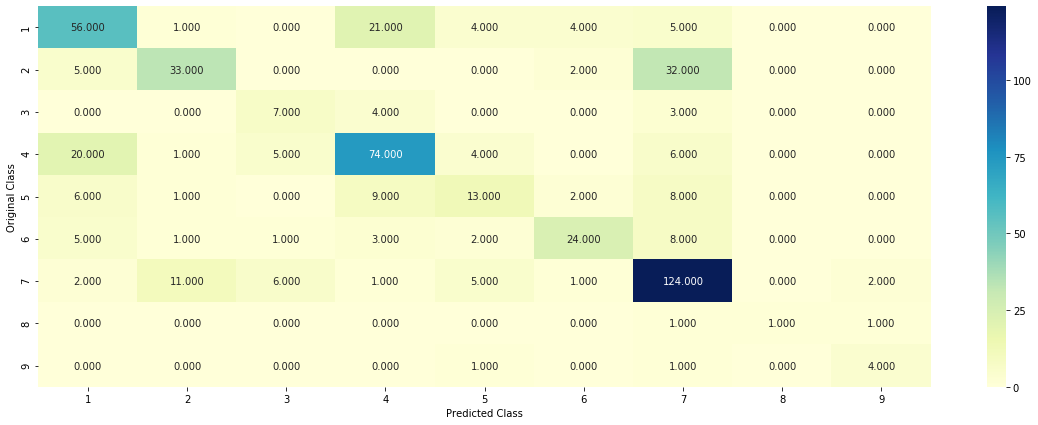

-------------------- Precision matrix (Columm Sum=1) --------------------


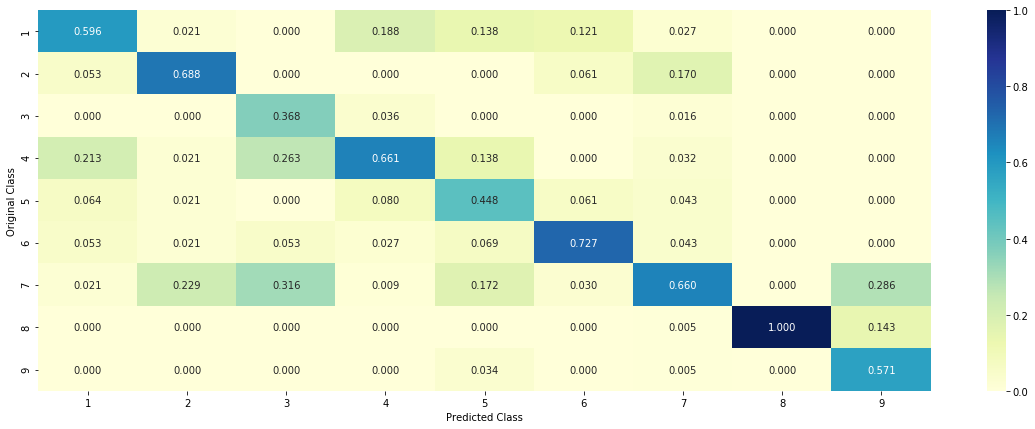

-------------------- Recall matrix (Row sum=1) --------------------


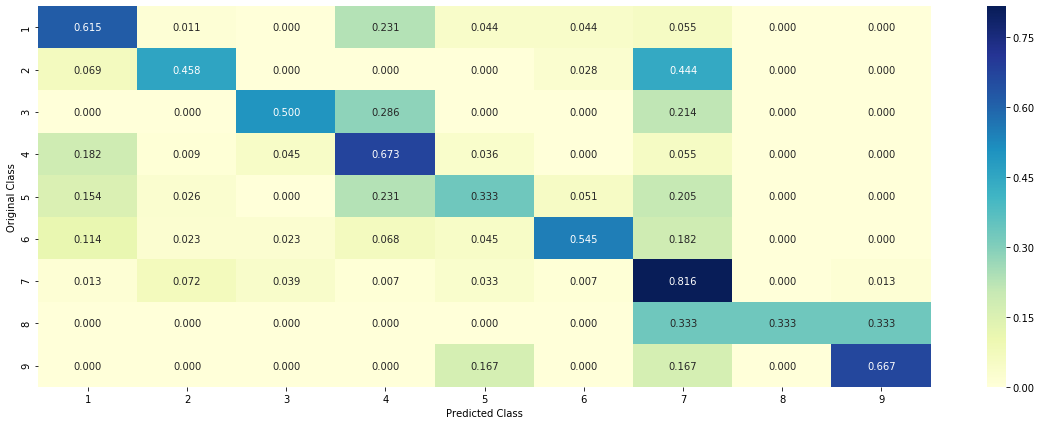

In [107]:
# read more about support vector machines with linear kernals here http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html

# --------------------------------
# default parameters 
# SVC(C=1.0, kernel=’rbf’, degree=3, gamma=’auto’, coef0=0.0, shrinking=True, probability=False, tol=0.001, 
# cache_size=200, class_weight=None, verbose=False, max_iter=-1, decision_function_shape=’ovr’, random_state=None)

# Some of methods of SVM()
# fit(X, y, [sample_weight])	Fit the SVM model according to the given training data.
# predict(X)	Perform classification on samples in X.
# --------------------------------
# video link: https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/mathematical-derivation-copy-8/
# --------------------------------


# clf = SVC(C=alpha[best_alpha],kernel='linear',probability=True, class_weight='balanced')
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=42,class_weight='balanced')
predict_and_plot_confusion_matrix(train_x_onehotCoding, train_y,cv_x_onehotCoding,cv_y, clf)

In [108]:
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=42)
clf.fit(train_x_onehotCoding,train_y)
test_point_index = 1
# test_point_index = 100
no_feature = 500
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.coef_)[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 2
Predicted Class Probabilities: [[0.102  0.4185 0.0079 0.0616 0.0599 0.0241 0.3119 0.0112 0.0029]]
Actual Class : 2
--------------------------------------------------
65 Text feature [md] present in test data point [True]
245 Text feature [achieved] present in test data point [True]
258 Text feature [serpentine] present in test data point [True]
260 Text feature [durable] present in test data point [True]
Out of the top  500  features  4 are present in query point


In [109]:
test_point_index = 100
no_feature = 500
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.coef_)[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 1
Predicted Class Probabilities: [[0.3397 0.0721 0.0128 0.0742 0.2751 0.1418 0.0621 0.0179 0.0042]]
Actual Class : 5
--------------------------------------------------
123 Text feature [discriminates] present in test data point [True]
217 Text feature [binomial] present in test data point [True]
248 Text feature [exceeding] present in test data point [True]
295 Text feature [definition] present in test data point [True]
349 Text feature [c8] present in test data point [True]
384 Text feature [language] present in test data point [True]
388 Text feature [89] present in test data point [True]
393 Text feature [deletion] present in test data point [True]
Out of the top  500  features  8 are present in query point


RANDOM FOREST

In [112]:
#one hot

In [113]:
# --------------------------------
# default parameters 
# sklearn.ensemble.RandomForestClassifier(n_estimators=10, criterion=’gini’, max_depth=None, min_samples_split=2, 
# min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features=’auto’, max_leaf_nodes=None, min_impurity_decrease=0.0, 
# min_impurity_split=None, bootstrap=True, oob_score=False, n_jobs=1, random_state=None, verbose=0, warm_start=False, 
# class_weight=None)

# Some of methods of RandomForestClassifier()
# fit(X, y, [sample_weight])	Fit the SVM model according to the given training data.
# predict(X)	Perform classification on samples in X.
# predict_proba (X)	Perform classification on samples in X.

# some of attributes of  RandomForestClassifier()
# feature_importances_ : array of shape = [n_features]
# The feature importances (the higher, the more important the feature).

# --------------------------------
# video link: https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/random-forest-and-their-construction-2/
# --------------------------------


# find more about CalibratedClassifierCV here at http://scikit-learn.org/stable/modules/generated/sklearn.calibration.CalibratedClassifierCV.html
# ----------------------------
# default paramters
# sklearn.calibration.CalibratedClassifierCV(base_estimator=None, method=’sigmoid’, cv=3)
#
# some of the methods of CalibratedClassifierCV()
# fit(X, y[, sample_weight])	Fit the calibrated model
# get_params([deep])	Get parameters for this estimator.
# predict(X)	Predict the target of new samples.
# predict_proba(X)	Posterior probabilities of classification
#-------------------------------------
# video link:
#-------------------------------------

alpha = [100,200,500,1000,2000]
max_depth = [5, 10]
cv_log_error_array = []
for i in alpha:
    for j in max_depth:
        print("for n_estimators =", i,"and max depth = ", j)
        clf = RandomForestClassifier(n_estimators=i, criterion='gini', max_depth=j, random_state=42, n_jobs=-1)
        clf.fit(train_x_onehotCoding, train_y)
        sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
        sig_clf.fit(train_x_onehotCoding, train_y)
        sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
        cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
        print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

'''fig, ax = plt.subplots()
features = np.dot(np.array(alpha)[:,None],np.array(max_depth)[None]).ravel()
ax.plot(features, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[int(i/2)],max_depth[int(i%2)],str(txt)), (features[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()
'''

best_alpha = np.argmin(cv_log_error_array)
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/2)], criterion='gini', max_depth=max_depth[int(best_alpha%2)], random_state=42, n_jobs=-1)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best estimator = ', alpha[int(best_alpha/2)], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best estimator = ', alpha[int(best_alpha/2)], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best estimator = ', alpha[int(best_alpha/2)], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

for n_estimators = 100 and max depth =  5
Log Loss : 1.2427176103826265
for n_estimators = 100 and max depth =  10
Log Loss : 1.1891320719248704
for n_estimators = 200 and max depth =  5
Log Loss : 1.2358189427937258
for n_estimators = 200 and max depth =  10
Log Loss : 1.1843797230145048
for n_estimators = 500 and max depth =  5
Log Loss : 1.2207481224271082
for n_estimators = 500 and max depth =  10
Log Loss : 1.1720658528297994
for n_estimators = 1000 and max depth =  5
Log Loss : 1.2123640987739992
for n_estimators = 1000 and max depth =  10
Log Loss : 1.1696993633776158
for n_estimators = 2000 and max depth =  5
Log Loss : 1.2074962887454879
for n_estimators = 2000 and max depth =  10
Log Loss : 1.1676563967650326
For values of best estimator =  2000 The train log loss is: 0.7054966530908028
For values of best estimator =  2000 The cross validation log loss is: 1.1676563967650326
For values of best estimator =  2000 The test log loss is: 1.1707256150161613


Log loss : 1.1676563967650326
Number of mis-classified points : 0.4105461393596987
-------------------- Confusion matrix --------------------


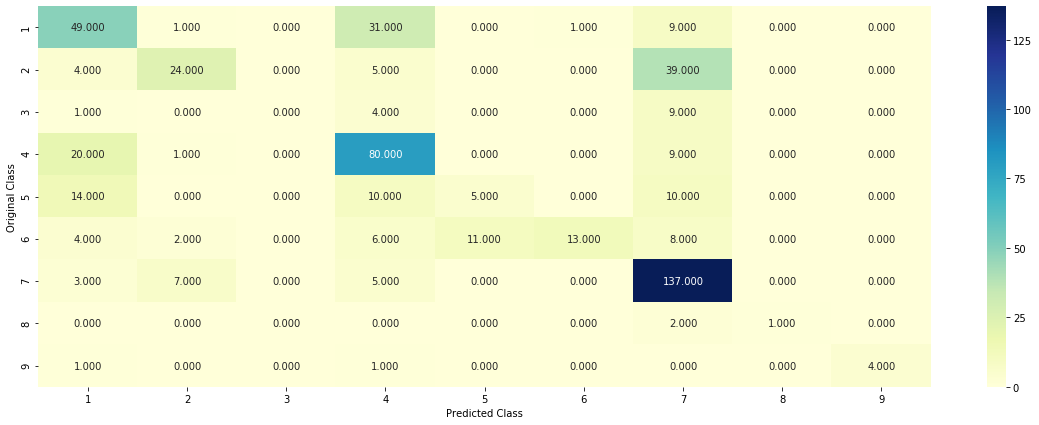

-------------------- Precision matrix (Columm Sum=1) --------------------


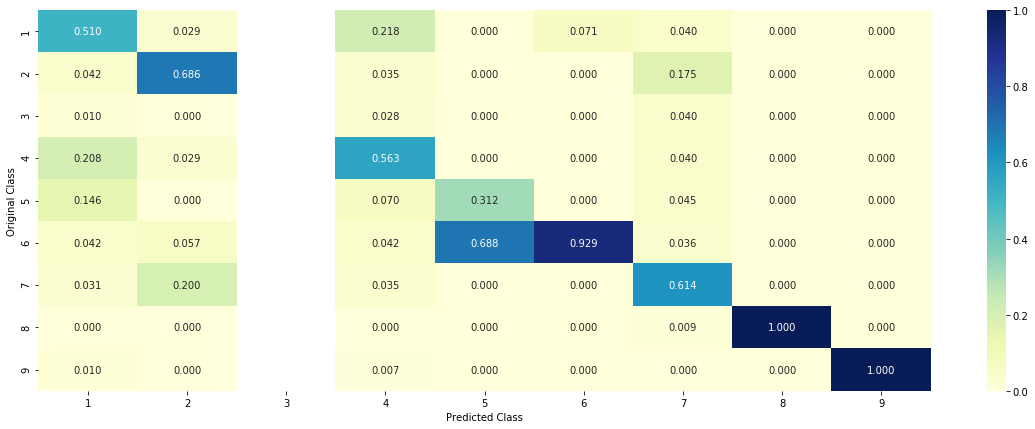

-------------------- Recall matrix (Row sum=1) --------------------


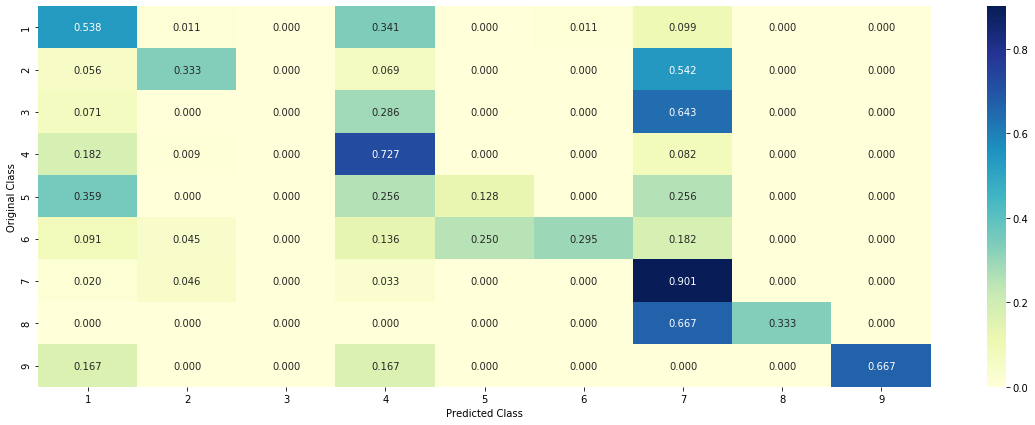

In [114]:
# --------------------------------
# default parameters 
# sklearn.ensemble.RandomForestClassifier(n_estimators=10, criterion=’gini’, max_depth=None, min_samples_split=2, 
# min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features=’auto’, max_leaf_nodes=None, min_impurity_decrease=0.0, 
# min_impurity_split=None, bootstrap=True, oob_score=False, n_jobs=1, random_state=None, verbose=0, warm_start=False, 
# class_weight=None)

# Some of methods of RandomForestClassifier()
# fit(X, y, [sample_weight])	Fit the SVM model according to the given training data.
# predict(X)	Perform classification on samples in X.
# predict_proba (X)	Perform classification on samples in X.

# some of attributes of  RandomForestClassifier()
# feature_importances_ : array of shape = [n_features]
# The feature importances (the higher, the more important the feature).

# --------------------------------
# video link: https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/random-forest-and-their-construction-2/
# --------------------------------

clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/2)], criterion='gini', max_depth=max_depth[int(best_alpha%2)], random_state=42, n_jobs=-1)
predict_and_plot_confusion_matrix(train_x_onehotCoding, train_y,cv_x_onehotCoding,cv_y, clf)